# Case Study - Travel Package Purchase Prediction

# **Background and Context:**

You are a Data Scientist for a tourism company named "Visit with us". The Policy Maker of the company wants to enable and establish a viable business model to expand the customer base.

A viable business model is a central concept that helps you to understand the existing ways of doing the business and how to change the ways for the benefit of the tourism sector.

One of the ways to expand the customer base is to introduce a new offering of packages.

Currently, there are 5 types of packages the company is offering - Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages.

However, the marketing cost was quite high because customers were contacted at random without looking at the available information.


# **Problem Statement:**
The company is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well being.

However, this time company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient.

You as a Data Scientist at "Visit with us" travel company has to analyze the customers' data and information to provide recommendations to the Policy Maker and Marketing Team and also build a model to predict the potential customer who is going to purchase the newly introduced package.

# **Objective:**

To predict which customer is more likely to purchase the long term travel package.

# **Data Description/Dictionary:**

### Customer details:
- CustomerID: Unique customer ID
- ProdTaken: Product taken flag
- Age: Age of customer
- PreferredLoginDevice: Preferred login device of the customer in last month
- CityTier: City tier
- Occupation: Occupation of customer
- Gender: Gender of customer
- NumberOfPersonVisited: Total number of person came with customer
- PreferredPropertyStar: Preferred hotel property rating by customer
- MaritalStatus: Marital status of customer
- NumberOfTrips: Average number of the trip in a year by customer
- Passport: Customer passport flag
- OwnCar: Customers owns a car flag
- NumberOfChildrenVisited: Total number of children visit with customer
- Designation: Designation of the customer in the current organization
- MonthlyIncome: Gross monthly income of the customer

### Customer interaction data: 

- PitchSatisfactionScore: Sales pitch satisfactory score
- ProductPitched: Product pitched by a salesperson
- NumberOfFollowups: Total number of follow up has been done by sales person after sales pitch
- DurationOfPitch: Duration of the pitch by a salesman to customer

## Index

- [Perform an Exploratory Data Analysis](#1)

- [Illustrate the Insights based on the EDA](#2)

- [Data Pre-processing](#3)

- [Model building - Bagging](#4)

- [Model Performance Evaluation and Improvement - Bagging](#5)

- [Model building - Boosting](#6)

- [Model Performance Evaluation and Improvement - Boosting](#7)

- [Actionable Insights & Recommendations](#8)

#### Install Packages

In [ ]:
pip install --upgrade numpy

In [ ]:
pip install --upgrade pandas

In [ ]:
pip install --upgrade matplotlib

In [ ]:
pip install --upgrade seaborn

In [ ]:
pip install --upgrade sklearn

In [ ]:
pip install --upgrade xgboost

In [ ]:
pip install --upgrade openpyxl

In [ ]:
pip install --upgrade xlrd

In [ ]:
pip install --upgrade scikit-plot

#### Importing Libraries

In [10]:
import warnings
warnings.filterwarnings("ignore")

from time import time
import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import plot_partial_dependence

import scikitplot as skplt

#### Creating Library of Functions

In [11]:
# Function used to Create a Combo Plot with a Boxplot and a Histogram

def histogram_boxplot(feature):
    sns.set({'figure.figsize': (12, 6)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, gridspec_kw = {"height_ratios": (.25, .75)})
    sns.boxplot(feature, showmeans = True, color='violet', ax = ax1)
    g = sns.histplot(feature, bins = 50, ax = ax2)
    g.axvline(np.mean(feature), color = 'green', linestyle = '--') # Add mean to the histogram
    g.axvline(np.median(feature), color = 'black', linestyle = '-') # Add median to the histogram

In [12]:
# Countplots with Percentages (Univariate Analysis & Bivariate Analysis)
# Combo Countplot with overall Percentages (top graph) and Percentages Split (based on the 'hue' variable) within each Category (bottom graph)

def percentage_on_bar(feature, hue):
    sns.set({'figure.figsize': (21, 10)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    total = len(feature)
    
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharey = True)
    
    plt1 = sns.countplot(x = feature, data = data, ax = ax1)
    height1 = [0] * feature.nunique()
    counter = 0
    for p in plt1.patches:
        height1[counter] = p.get_height()
        plt1.text(p.get_x() + p.get_width() / 2, height1[counter] + 5, '{:1.2f}'.format(100 * height1[counter] / total) + "%", ha = "center")
        counter = counter + 1
        
    height1_hue = 2 * height1

    plt2 = sns.countplot(x = feature, hue = hue, data = data, ax = ax2)
    counter = 0
    for p in plt2.patches:
        height2 = p.get_height()
        plt2.text(p.get_x() + p.get_width() / 2, height2 + 5, '{:1.2f}'.format(100 * height2 / height1_hue[counter]) + "%", ha = "center")
        counter = counter + 1
    plt2.legend(loc = 'upper right', title = 'Product Taken', framealpha = 1, shadow = True, borderpad = 1);

In [13]:
# Function to get a Confusion Matrix with Percentages

def make_confusion_matrix(model, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels = [0, 1])
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = cm.flatten()
    group_percentages = np.round(100*group_counts/np.sum(group_counts), 2)
    
    labels = [f"{v1}\n{v2}\n{v3}%" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (7,5))
    sns.set_context("talk")
    sns.heatmap(cm, annot = labels,  fmt = '', xticklabels = ["0", "1"] , yticklabels = ["0", "1"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [14]:
##  Function to Calculate Different Metric Scores of the Model - Accuracy, Recall, Precision, F1 Score and ROC AUC Score

def get_metrics_score(model, flag = True):
    
     # defining an empty list to store train and test results
    score_list=[] 
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = round(model.score(X_train, y_train), 3)
    test_accuracy = round(accuracy_score(y_test, y_pred_test), 3)
    train_recall = round(recall_score(y_train, y_pred_train), 3)
    test_recall = round(recall_score(y_test, y_pred_test), 3)
    train_precision = round(precision_score(y_train, y_pred_train), 3)
    test_precision = round(precision_score(y_test, y_pred_test), 3)
    train_F1_score = round(f1_score(y_train, y_pred_train), 3)
    test_F1_score = round(f1_score(y_test, y_pred_test), 3)
    ROC_AUC_score = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
      
    score_list.extend((train_accuracy, test_accuracy, train_recall, test_recall, train_precision, test_precision, train_F1_score, test_F1_score, ROC_AUC_score))
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Train Accuracy =", train_accuracy)
        print("Test Accuracy =", test_accuracy)
        print("Train Recall =", train_recall)
        print("Test Recall =", test_recall)
        print("Train Precision =", train_precision)
        print("Test Precision =", test_precision)
        print("Train F1 Score:", train_F1_score)
        print("Test F1 Score:", test_F1_score)
        print("ROC AUC Score:", ROC_AUC_score)
        
    return score_list # returning the list with train and test scores

In [15]:
##  Function to Calculate Features Importance

def features_importance(model):
    fi = pd.DataFrame(model.feature_importances_, columns = ["Importance"], index = X_train.columns).reset_index().sort_values(by = 'Importance', ascending = False)
    # Features Importance
    sns.set({'figure.figsize': (12, 12)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    total = fi['Importance'].sum()
    g = sns.barplot(x = "Importance", y = "index", order = fi['index'], orient = 'h', data = fi)
    sns.despine()
    for p in g.patches:
        g.text(x = p.get_width() + 0.0005, y = p.get_y() + p.get_height() / 2, s = '{:1.2f}'.format(100 * p.get_width() / total) + "%", va = "center")
    g.set(ylabel = None)
    plt.title('Features Importance');

***
## Perform an Exploratory Data Analysis <a class="anchor" id="1"></a>

- Univariate analysis
- Bivariate analysis
- Use appropriate visualizations to identify the patterns and insights
- Come up with a customer profile (characteristics of a customer) of the different packages
- Any other exploratory deep dive

#### Load the Dataset, Chech First 05 Rows, Check Data Shape, Data Types, Number of Null Values and Unique Categories for each Variable

In [16]:
# Loading Dataset
data = pd.read_excel('Tourism.xlsx', sheet_name = 'Tourism', header = 0, engine='openpyxl')

In [17]:
# Checking First 05 Rows
data.head()

CustomerID  ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
0      200000          1  41.0     Self Enquiry         3              6.0   
1      200001          0  49.0  Company Invited         1             14.0   
2      200002          1  37.0     Self Enquiry         1              8.0   
3      200003          0  33.0  Company Invited         1              9.0   
4      200004          0   NaN     Self Enquiry         1              8.0   

       Occupation  Gender  NumberOfPersonVisited  NumberOfFollowups  \
0        Salaried  Female                      3                3.0   
1        Salaried    Male                      3                4.0   
2     Free Lancer    Male                      3                4.0   
3        Salaried  Female                      2                3.0   
4  Small Business    Male                      2                3.0   

  ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
0         Deluxe                    3.0        Single            1.0   
1         Deluxe                    4.0      Divorced            2.0   
2          Basic                    3.0        Single            7.0   
3          Basic                    3.0      Divorced            2.0   
4          Basic                    4.0      Divorced            1.0   

   Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisited  \
0         1                       2       1                      0.0   
1         0                       3       1                      2.0   
2         1                       3       0                      0.0   
3         1                       5       1                      1.0   
4         0                       5       1                      0.0   

  Designation  MonthlyIncome  
0     Manager        20993.0  
1     Manager        20130.0  
2   Executive        17090.0  
3   Executive        17909.0  
4   Executive        18468.0

In [18]:
# Checking Data Shape
data.shape

(4888, 20)

- There are total 20 columns and 4,888 rows in the dataset.

In [19]:
# Checking Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               4888 non-null   int64  
 1   ProdTaken                4888 non-null   int64  
 2   Age                      4662 non-null   float64
 3   TypeofContact            4863 non-null   object 
 4   CityTier                 4888 non-null   int64  
 5   DurationOfPitch          4637 non-null   float64
 6   Occupation               4888 non-null   object 
 7   Gender                   4888 non-null   object 
 8   NumberOfPersonVisited    4888 non-null   int64  
 9   NumberOfFollowups        4843 non-null   float64
 10  ProductPitched           4888 non-null   object 
 11  PreferredPropertyStar    4862 non-null   float64
 12  MaritalStatus            4888 non-null   object 
 13  NumberOfTrips            4748 non-null   float64
 14  Passport                

- The data types for all the columns are either integer, float or object.
- 'TypeofContact', 'Occupation', 'Gender', 'ProductPitched, 'MaritalStatus' and 'Designation' are Object type (Categorical) variables.
- 'CustomerID' has a unique value for each row in the dataset. This variable will be deleted as it is an ID variable and will not add value to the model.

In [20]:
# Dropping 'CustomerID' from the Dataset
data.drop(columns = ['CustomerID'], inplace = True)

- 'CustomerID' variable was deleted from the dataset

In [21]:
# Checking Number of Missing Values per Variable
data.isnull().sum().sort_values(ascending = False)

DurationOfPitch            251
MonthlyIncome              233
Age                        226
NumberOfTrips              140
NumberOfChildrenVisited     66
NumberOfFollowups           45
PreferredPropertyStar       26
TypeofContact               25
Designation                  0
OwnCar                       0
PitchSatisfactionScore       0
Passport                     0
ProdTaken                    0
MaritalStatus                0
NumberOfPersonVisited        0
Gender                       0
Occupation                   0
CityTier                     0
ProductPitched               0
dtype: int64

- There are several missing values in the dataset for 'DurationOfPitch', 'MonthlyIncome', 'Age', 'NumberOfTrips', 'NumberOfChildrenVisited', 'NumberOfFollowups', 'PreferredPropertyStar' and 'TypeofContact', and their respective counts are listed on the table above. 
- These missing values will be treated with the correct imputations as next steps (along with the Univariate Analysis).

In [22]:
# Check Unique Categories for each Variable
data.nunique().sort_values(ascending = False)

MonthlyIncome              2475
Age                          44
DurationOfPitch              34
NumberOfTrips                12
NumberOfFollowups             6
Designation                   5
PitchSatisfactionScore        5
ProductPitched                5
NumberOfPersonVisited         5
MaritalStatus                 4
Occupation                    4
NumberOfChildrenVisited       4
Gender                        3
PreferredPropertyStar         3
CityTier                      3
Passport                      2
OwnCar                        2
TypeofContact                 2
ProdTaken                     2
dtype: int64

- 'MonthlyIncome', 'Age' and 'DurationOfPitch' are Numeric/Continuous variables since they are numeric (float64) and have several unique categories in comparison with the other variables.

In [23]:
# Check Uniques Categories Values per Variable (Removing Numeric/Continuous Variables: 'MonthlyIncome', 'Age' and 'DurationOfPitch')
cat_cols = ['ProdTaken', 'TypeofContact', 'CityTier', 'Occupation', 'Gender', 'NumberOfPersonVisited', 'NumberOfFollowups', 'ProductPitched',\
            'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisited', 'Designation']
for column in cat_cols :
    print(data[column].value_counts(normalize = False))
    print()
    print('-'*30)

0    3968
1     920
Name: ProdTaken, dtype: int64

------------------------------
Self Enquiry       3444
Company Invited    1419
Name: TypeofContact, dtype: int64

------------------------------
1    3190
3    1500
2     198
Name: CityTier, dtype: int64

------------------------------
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64

------------------------------
Male       2916
Female     1817
Fe Male     155
Name: Gender, dtype: int64

------------------------------
3    2402
2    1418
4    1026
1      39
5       3
Name: NumberOfPersonVisited, dtype: int64

------------------------------
4.0    2068
3.0    1466
5.0     768
2.0     229
1.0     176
6.0     136
Name: NumberOfFollowups, dtype: int64

------------------------------
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64

------------------------------
3.0    2993
5

- 'ProdTaken' is a Categorical/Ordinal/Boolean variable, having 02 distinct categories (0 or 1). This variable is the Dependent Variable for the classification model.
- 'TypeofContact' is a Categorical/Nominal variable, having 02 distinct categories ('Self Enquiry' and 'Company Invited').
- 'CityTier', 'NumberOfPersonVisited', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'PitchSatisfactionScore', 'NumberOfChildrenVisited' are Numeric/Discrete variables.
- 'Occupation' is a Categorical/Nominal variable, having 04 distinct categories ('Salaried', 'Small Business', 'Large Business' and 'Free Lancer').
- 'Gender' is a Categorical/Nominal variable with 03 distinct categories ('Male', 'Female', 'Fe Male'). The category 'Fe Male' needs to be fixed (replaced by 'Female').
- 'ProductPitched' is a Categorical/Nominal variable, having 05 distinct categories ('Basic', 'Deluxe', 'Standard' and 'Super Deluxe' and 'King'). This variable represents available package types offered by the tourism company.
- 'MaritalStatus' is a Categorical/Nominal variable, having 04 distinct categories ('Married', 'Divorced', 'Single' and 'Unmarried').
- 'Passport' and 'OwnCar' are Categorical/Ordinal/Boolean variables, having 02 distinct categories (0 or 1). In statistics context, Boolean variables are considered Categorical variables in this case, Categorical/Ordinal.
- 'Designation' is a Categorical/Nominal variable, having 05 distinct categories ('Executive', 'Manager', 'Senior Manager' and 'AVP' and 'VP').

In [24]:
# Fixing 'Gender' categories
data['Gender'].replace({'Fe Male':'Female'}, inplace = True)

In [25]:
data['Gender'].value_counts(normalize = False)

Male      2916
Female    1972
Name: Gender, dtype: int64

- 'Gender' category 'Fe Male' was fixed (replaced by 'Female').

#### Univariate Analysis for Numeric/Continuous Variables: 'Age', 'DurationOfPitch' and 'MonthlyIncome'

In [26]:
# Checking Number of Null Values Numeric/Continuous Variables
data[['Age', 'DurationOfPitch', 'MonthlyIncome']].isnull().sum()

Age                226
DurationOfPitch    251
MonthlyIncome      233
dtype: int64

##### Univariate Analysis for 'Age'

In [27]:
# Checking Missing values for 'Age' before the Imputations
data[['Age']].isnull().sum()

Age    226
dtype: int64

In [28]:
# Checking Skewness for 'Age'
data[['Age']].skew()

Age    0.382989
dtype: float64

In [29]:
# Mean Imputation for 'Age'. A rounded mean imputation was used in this case.
# Mean Imputation was the choice to handle missing values because 'Age' exhibits low skweness
data['Age'] = data['Age'].fillna(round(data['Age'].mean(axis = 0)))

In [30]:
# Checking Missing values for 'Age' after the Imputations
data[['Age']].isnull().sum()

Age    0
dtype: int64

In [31]:
print(data[['Age']].describe())
print()
print(data[['Age']].skew())

               Age
count  4888.000000
mean     37.639730
std       9.098764
min      18.000000
25%      31.000000
50%      37.000000
75%      43.000000
max      61.000000

Age    0.386354
dtype: float64


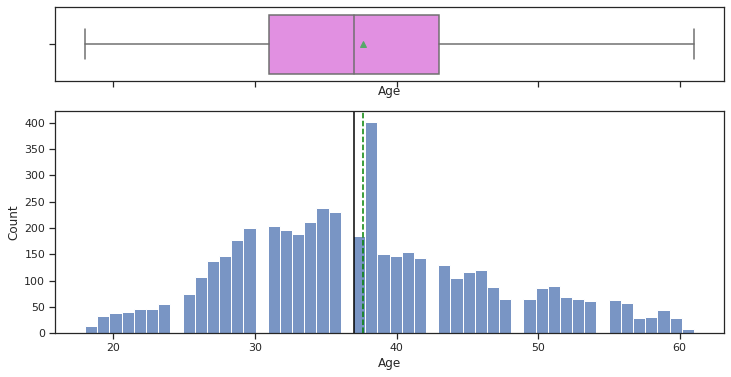

In [32]:
histogram_boxplot(data['Age'])

- A rounded Mean Imputation strategy was the choice to handle missing values on 'Age' because its distribution exbihits low skweness.
- With all the imputations for the missing values, 'Age' is ranging from 18 to 61 years, with mean and median at 37.64 and 37, respectively. It's very close to a symmetrical distribution (low right skewness of 0.39).

##### Univariate Analysis for 'DurationOfPitch'

In [33]:
# Checking Skewness for 'DurationOfPitch'
data[['DurationOfPitch']].skew()

DurationOfPitch    1.752037
dtype: float64

In [34]:
# Checking Missing values for 'DurationOfPitch' before the Imputations
data[['DurationOfPitch']].isnull().sum()

DurationOfPitch    251
dtype: int64

In [35]:
# Median Imputation for 'DurationOfPitch'
# Median Imputation was the choice to handle missing values because 'DurationOfPitch' exhibits some relevant degree of skweness
data['DurationOfPitch'] = data['DurationOfPitch'].fillna(data['DurationOfPitch'].median(axis = 0))

In [36]:
# Checking Missing values for 'DurationOfPitch' after the Imputations
data[['DurationOfPitch']].isnull().sum()

DurationOfPitch    0
dtype: int64

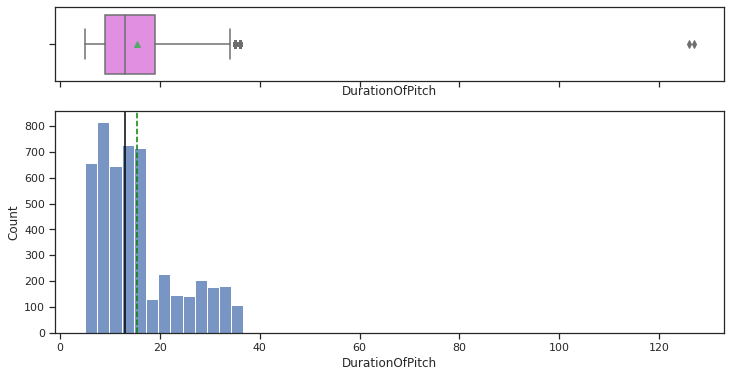

In [37]:
histogram_boxplot(data['DurationOfPitch'])

In [38]:
# Top 03 Highest Values - Checking the Outliers
data['DurationOfPitch'].nlargest(n = 3)

3878    127.0
1434    126.0
2505     36.0
Name: DurationOfPitch, dtype: float64

In [39]:
# Treating the Outliers presented in 'DurationOfPitch'
Q1 = data['DurationOfPitch'].quantile(0.25)
Q3 = data['DurationOfPitch'].quantile(0.75)
IQR = Q3 - Q1
Upper_whisker = Q1 + 1.5 * IQR

In [40]:
# The choice to treat the outliers in 'DurationOfPitch' was a replacement with the upper whisker values
data.loc[1434,'DurationOfPitch'] = Upper_whisker
data.loc[3878,'DurationOfPitch'] = Upper_whisker

In [41]:
print(data[['DurationOfPitch']].describe())
print()
print(data[['DurationOfPitch']].skew())

       DurationOfPitch
count      4888.000000
mean         15.320990
std           8.008275
min           5.000000
25%           9.000000
50%          13.000000
75%          19.000000
max          36.000000

DurationOfPitch    0.973203
dtype: float64


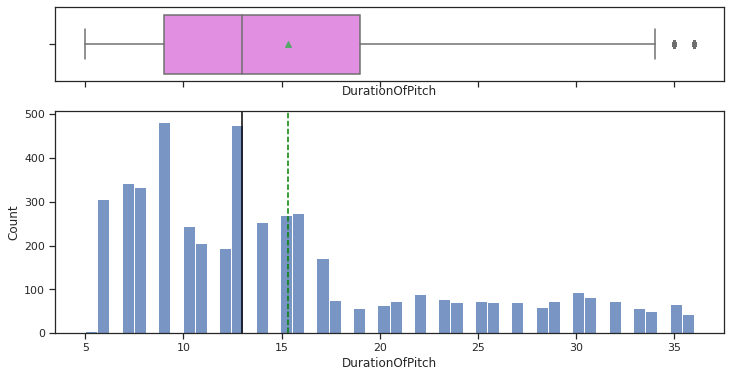

In [42]:
histogram_boxplot(data['DurationOfPitch'])

- A Median Imputation strategy was the choice to handle missing values on 'DurationOfPitch' because its distribution exhibits some relevant degree of skweness.
- With all the imputations for the missing values, the mean value is 15.32 and the median is 13. The standard deviation is 8.0.
- There were 02 more pronounced outliers to the higher side of the distribution (row# 1434 at 126.0, and row# 3878 at 127.0). These outliers were treated by replacing them with the values of the upper whisker (Q1 + 1.5 * IQR).
- In general, outliers won't necessarily represent a problem for tree-based classifiers, because their algorithms split the data points on the basis of same value and an outlier  won't affect that much the split. I initially ran all the analysis without treating the outliers and didn't see any relevant changes in the final metrics on different models, however I decided to go back and treat the outliers to get cleaner Univariate/Bivariate visualizations, and also to improve the best model explainability thru the Partial Dependence Plots (PDP) at the last session.

##### Univariate Analysis for 'MonthlyIncome'

In [43]:
# Checking Missing values for 'MonthlyIncome' before the Imputations
data[['MonthlyIncome']].isnull().sum()

MonthlyIncome    233
dtype: int64

In [44]:
# Average 'MonthlyIncome' by 'Designation'
average_income = data.groupby('Designation').mean()['MonthlyIncome']
average_income

Designation
AVP               32241.046784
Executive         19939.922507
Manager           22643.157629
Senior Manager    26637.749326
VP                35878.947826
Name: MonthlyIncome, dtype: float64

In [45]:
# The choice to treat the outliers in 'MonthlyIncome' was a replacement with the mean values per 'Designation' category
data.loc[(data['Designation'] == 'Manager') & (pd.isnull(data['MonthlyIncome'])), 'MonthlyIncome'] = average_income['Manager']
data.loc[(data['Designation'] == 'Senior Manager') & (pd.isnull(data['MonthlyIncome'])), 'MonthlyIncome'] = average_income['Senior Manager']
data.loc[(data['Designation'] == 'Executive') & (pd.isnull(data['MonthlyIncome'])), 'MonthlyIncome'] = average_income['Executive']
data.loc[(data['Designation'] == 'VP') & (pd.isnull(data['MonthlyIncome'])), 'MonthlyIncome'] = average_income['VP']
data.loc[(data['Designation'] == 'AVP') & (pd.isnull(data['MonthlyIncome'])), 'MonthlyIncome'] = average_income['AVP']

In [46]:
# Checking Missing values for 'MonthlyIncome' after the Imputations
data[['MonthlyIncome']].isnull().sum()

MonthlyIncome    0
dtype: int64

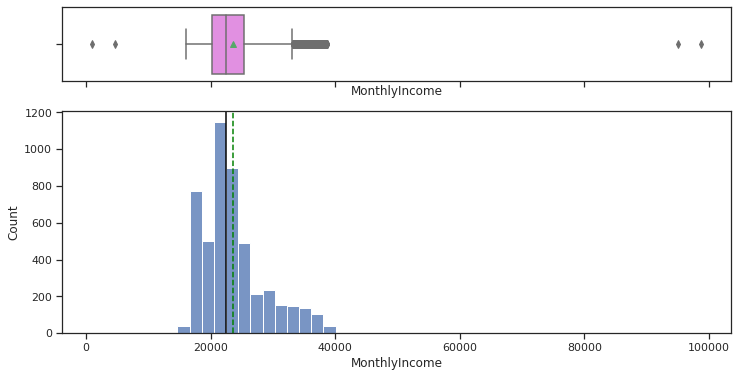

In [47]:
histogram_boxplot(data['MonthlyIncome'])

In [48]:
# 03 Highest Values - Checking the Outliers
data['MonthlyIncome'].nlargest(n = 3)

2482    98678.0
38      95000.0
2634    38677.0
Name: MonthlyIncome, dtype: float64

In [49]:
# 02 Lowest Values - Checking the Outliers
data['MonthlyIncome'].nsmallest(n = 3)

142      1000.0
2586     4678.0
513     16009.0
Name: MonthlyIncome, dtype: float64

In [50]:
# Outliers in the dataset
data[(data['MonthlyIncome'] > 38677) | (data['MonthlyIncome'] < 16009)].sort_values(by = 'MonthlyIncome')['Designation']

142       Manager
2586      Manager
38      Executive
2482    Executive
Name: Designation, dtype: object

In [51]:
# Both outliers on the lower side belong to the 'Manager' 'Designation' category, therefore their values will be replaced by the mean of this category
data.loc[142,'MonthlyIncome'] = average_income['Manager']
data.loc[2586,'MonthlyIncome'] = average_income['Manager']

In [52]:
# Both outliers on the higher side belong to the 'Executive' 'Designation' category, therefore their values will be replaced by the mean of this category
data.loc[38,'MonthlyIncome'] = average_income['Executive']
data.loc[2482,'MonthlyIncome'] = average_income['Executive']

In [53]:
print(data[['MonthlyIncome']].describe())
print()
print(data[['MonthlyIncome']].skew())

       MonthlyIncome
count    4888.000000
mean    23501.821283
std      5045.753877
min     16009.000000
25%     20275.500000
50%     22413.500000
75%     25407.750000
max     38677.000000

MonthlyIncome    1.089747
dtype: float64


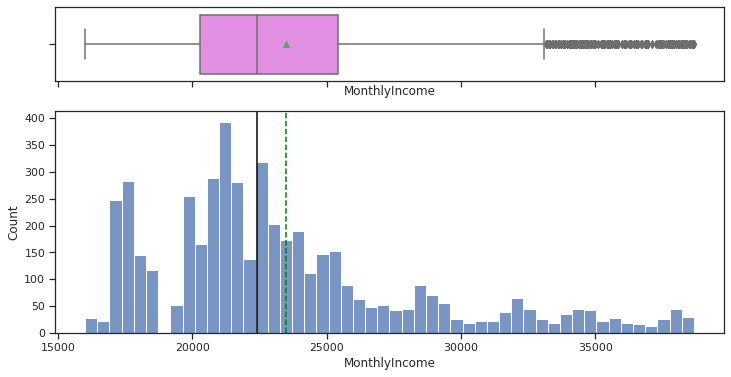

In [54]:
histogram_boxplot(data['MonthlyIncome'])

- A Mean Imputation strategy per 'Designation' category was the choice to handle missing values on 'MonthlyIncome'.
- With all the imputations for the missing values, the 'MonthlyIncome' mean is 23501.8 and the median is 22413.5.
- There were 02 outliers to the lower side of the distribution (row# 142 at 1000.0, and row# 2586 at 4678.0). These outliers were treated by replacing them with the values of the mean for the "Designation' of a 'Manager', since they both belonged to this category. 
- There were 02 other more pronounced outliers to the higher side of the distribution (row# 38 at 95000.0, and row# 2482 at 98678.0). These outliers were treated by replacing them with the values of the mean for the "Designation' of a 'Executive', since they both belonged to this category. Probably these outliers on the higher side were caused by wrong imputations of annual salaries instead of monthly salaries.
- In general, outliers won't necessarily represent a problem for tree-based classifiers, because their algorithms split the data points on the basis of same value and an outlier  won't affect that much the split. I initially ran all the analysis without treating the outliers and didn't see any relevant changes in the final metrics on different models, however I decided to go back and treat the outliers to get cleaner Univariate/Bivariate visualizations, and also to improve the best model explainability thru the Partial Dependence Plots (PDP) at the last session.

#### Bivariate Analysis for Numeric/Continuous Variables: 'Age', 'DurationOfPitch' and 'MonthlyIncome' vs. 'ProdTaken'

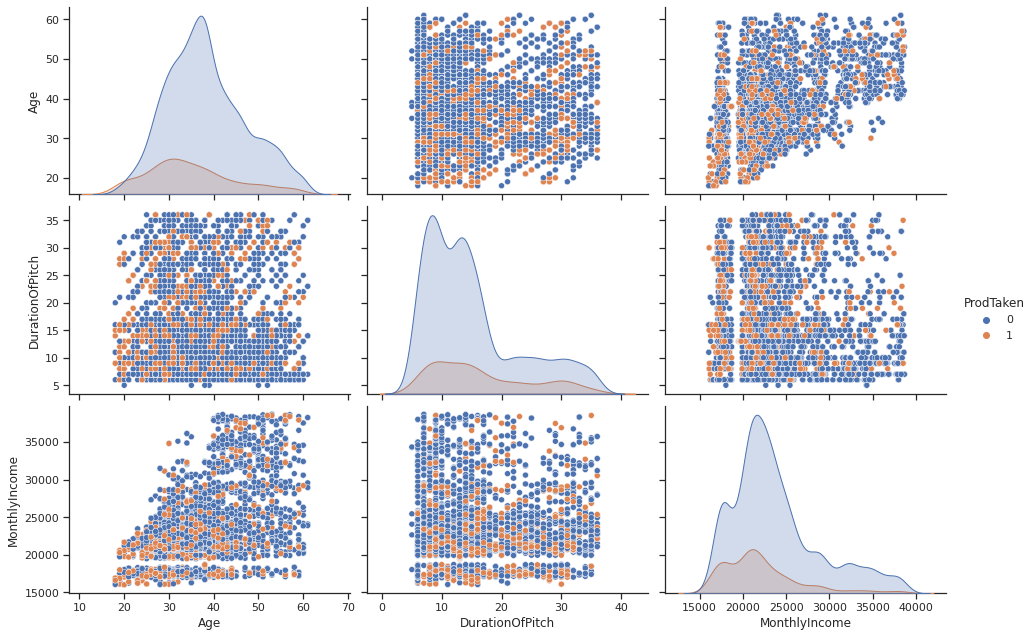

In [55]:
# Bivariate Analysis - Pairplot for Numeric/Continuous Variables
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")
sns.pairplot(data = data[['Age', 'DurationOfPitch', 'MonthlyIncome', 'ProdTaken']], hue = 'ProdTaken', height = 3, aspect = 1.5, corner = False);

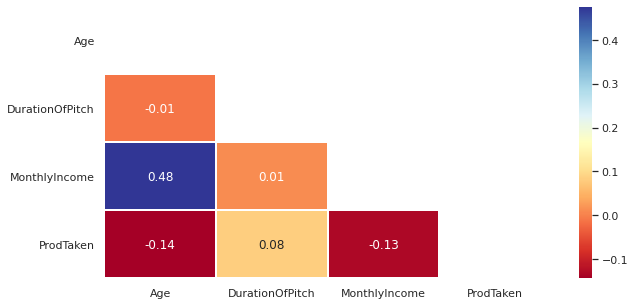

In [56]:
# Bivariate Analysis - Heatmap for Numeric/Continuous Variables
sns.set({'figure.figsize': (10,5)})
sns.set_style("whitegrid")
corr = data[['Age', 'DurationOfPitch', 'MonthlyIncome', 'ProdTaken']].corr()
lower_triangle = np.tril(corr, k = -1)
sns.set_context("notebook")
mask = lower_triangle == 0
sns.heatmap(data[['Age', 'DurationOfPitch', 'MonthlyIncome', 'ProdTaken']].corr(), annot = True, cmap = "RdYlBu", fmt = '.2f', linewidths = 0.05, mask = mask);

- There's a moderate positive correlation (+0.48) between 'Age' and 'MonthlyIncome', meaning that older people are more likely to make more money.
- None of the Numeric/Continuous Variables ('Age', 'DurationOfPitch' and 'MonthlyIncome') have a relevant correlation with 'ProdTaken'.

#### Univariate & Bivariate Analysis for Numeric/Discrete Variables:
#### 'CityTier', 'NumberOfPersonVisited', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'PitchSatisfactionScore' and 'NumberOfChildrenVisited'

In [57]:
# Checking Number of Null Values for Numeric/Discrete Variables
data[['CityTier', 'NumberOfPersonVisited', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'PitchSatisfactionScore', 'NumberOfChildrenVisited']].isnull().sum()

CityTier                     0
NumberOfPersonVisited        0
NumberOfFollowups           45
PreferredPropertyStar       26
NumberOfTrips              140
PitchSatisfactionScore       0
NumberOfChildrenVisited     66
dtype: int64

##### Univariate & Bivariate Analysis for 'CityTier'

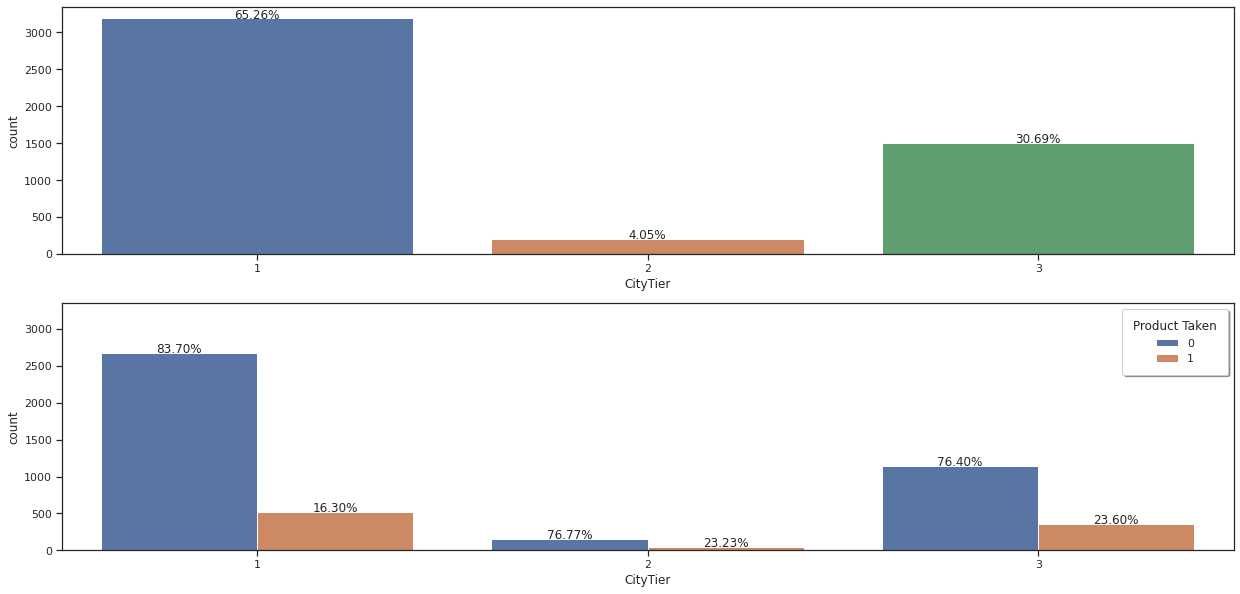

In [58]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(feature = data['CityTier'], hue = data['ProdTaken'])

- 'CityTier' categories 2 and 3 represent smaller splits in the dataset (4.05% and 30.69%, respectively), however they have a higher percentage of products taken (23.23% and 23.60%, respectively) when compared to "CityTier1" with 16.30%.

##### Univariate & Bivariate Analysis for 'NumberOfPersonVisited'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


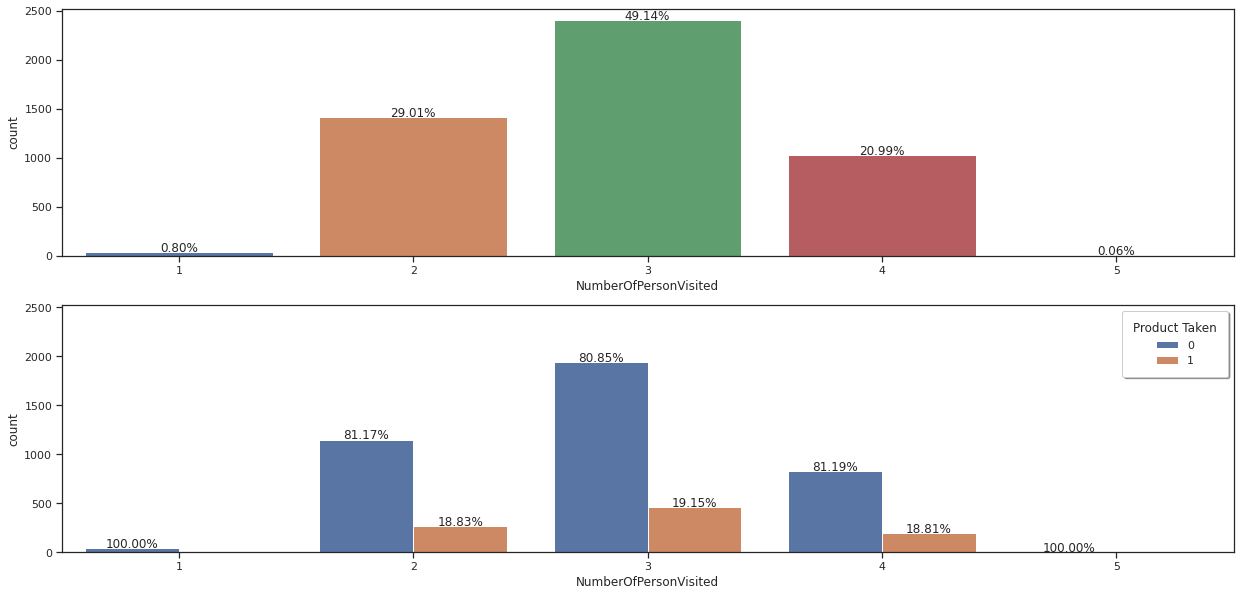

In [59]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['NumberOfPersonVisited'], hue = data['ProdTaken'])

- More frequent 'NumberOfPersonVisited' of 3 (49.14%) and neglibible occurences at 1 and 5 (less than 1% for their sum). Other categories presented approximate similar percentages of products taken (between 18.8% and 19.2%).

##### Univariate & Bivariate Analysis for 'NumberOfFollowups'

In [60]:
# Checking Missing values for 'NumberOfFollowups' before the Imputations
data[['NumberOfFollowups']].isnull().sum()

NumberOfFollowups    45
dtype: int64

In [61]:
# Treating missing values with the Mode Imputation for 'NumberOfFollowups'
data['NumberOfFollowups'].fillna(value = data['NumberOfFollowups'].mode()[0], inplace = True)

In [62]:
# Checking Missing values for 'NumberOfFollowups' after the Imputations
data[['NumberOfFollowups']].isnull().sum()

NumberOfFollowups    0
dtype: int64

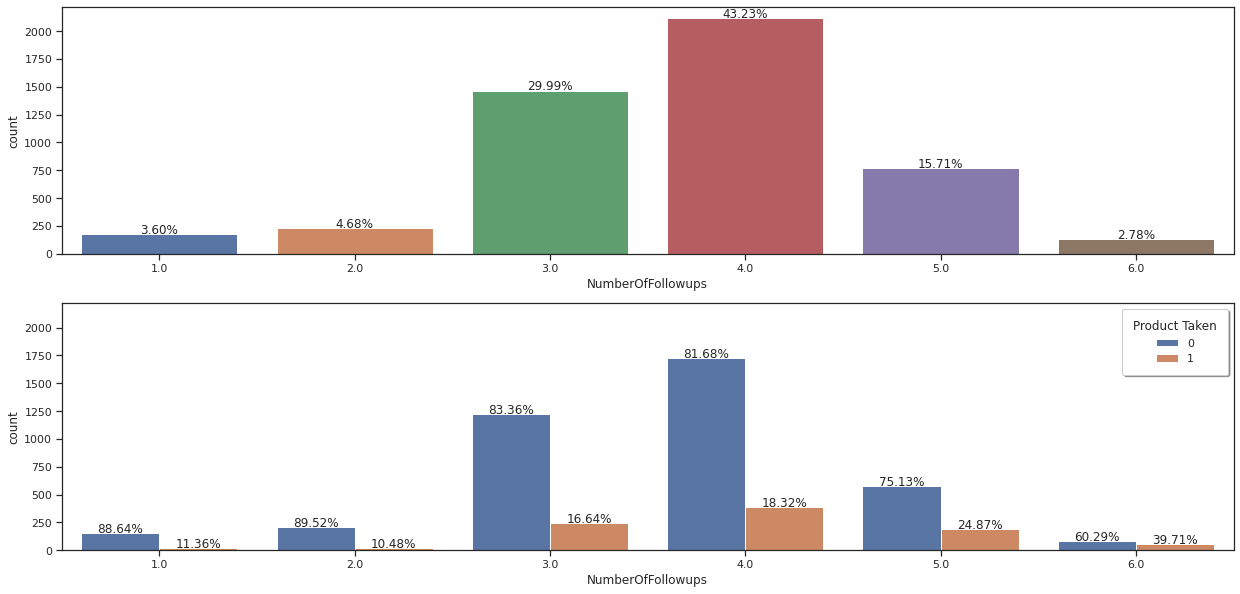

In [63]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['NumberOfFollowups'], hue = data['ProdTaken'])

- More frequent 'NumberOfFollowups' on category 4 (42.23%), followed by category 3 with 29.99%. Categories 5 and 6 with a higher percentage of products taken (24.87% and 39.71%, respectively) when compared to the other categories.
- The missing values for 'NumberOfFollowups' were treated with a Mode Imputation.

##### Univariate & Bivariate & Bivariate Analysis for 'PreferredPropertyStar'

In [64]:
# Checking Missing values for 'PreferredPropertyStar' before the Imputations
data[['PreferredPropertyStar']].isnull().sum()

PreferredPropertyStar    26
dtype: int64

In [65]:
# Treating missing values with the Mode Imputation for 'PreferredPropertyStar'
data['PreferredPropertyStar'].fillna(value = data['PreferredPropertyStar'].mode()[0], inplace = True)

In [66]:
# Checking Missing values for 'PreferredPropertyStar' after the Imputations
data[['PreferredPropertyStar']].isnull().sum()

PreferredPropertyStar    0
dtype: int64

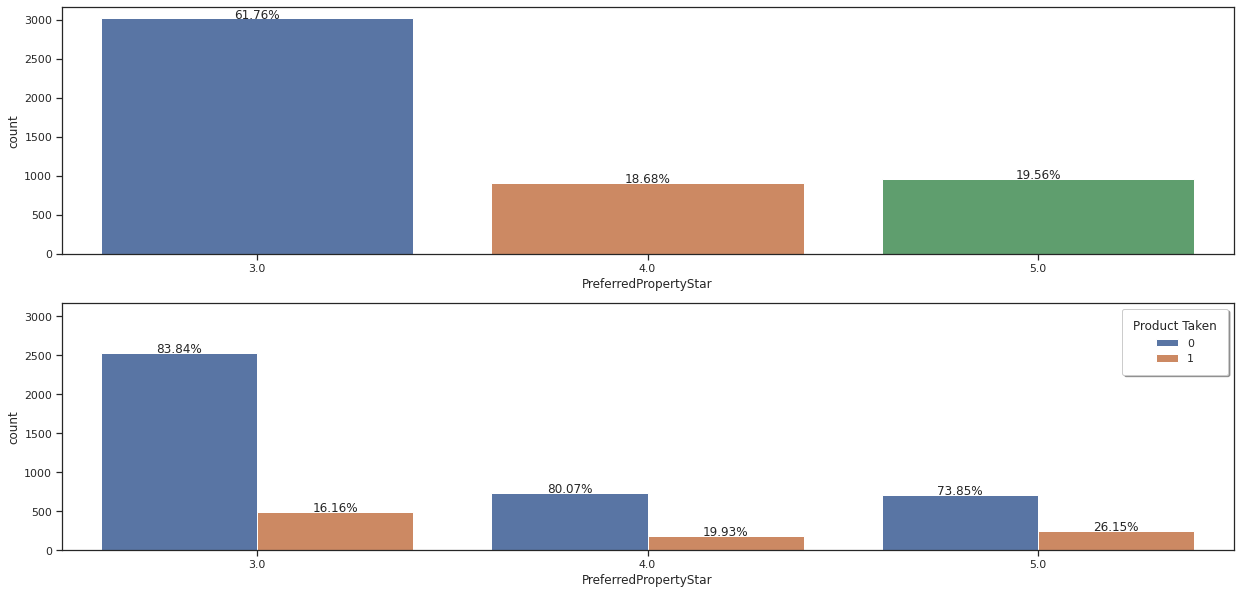

In [67]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['PreferredPropertyStar'], hue = data['ProdTaken'])

- More frequent 'PreferredPropertyStar' on category 3 (61.76%). Categories 4 and 5 with higher percentage of products taken (19.93% and 26.15%, respectively) when compared to category 3 (16.16%).
- The missing values for 'PreferredPropertyStar' were treated with a Mode Imputation.

##### Univariate & Bivariate Analysis for 'NumberOfTrips'

In [68]:
# Checking Missing values for 'NumberOfTrips' before the Imputations
data[['NumberOfTrips']].isnull().sum()

NumberOfTrips    140
dtype: int64

In [69]:
# Treating missing values with the Mode Imputation for 'NumberOfTrips'
data['NumberOfTrips'].fillna(value = data['NumberOfTrips'].mode()[0], inplace = True)

In [70]:
# Checking Missing values for 'NumberOfTrips' after the Imputations
data[['NumberOfTrips']].isnull().sum()

NumberOfTrips    0
dtype: int64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


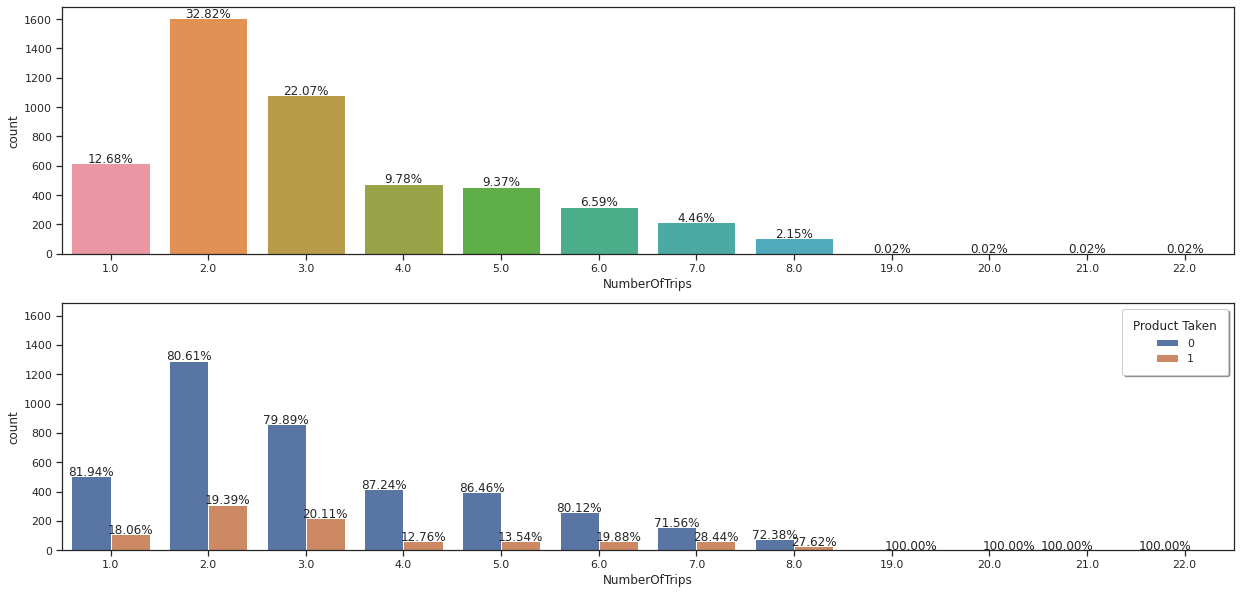

In [71]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph) - before treating the outliers
percentage_on_bar(data['NumberOfTrips'], hue = data['ProdTaken'])

In [72]:
# Less than 0.1% of the data entries with Values for 'NumberOfTrips' above 8. These outliers will be treated with the Mode Imputation.
data.loc[(data['NumberOfTrips'] > 8), 'NumberOfTrips'] = data['NumberOfTrips'].mode()[0]

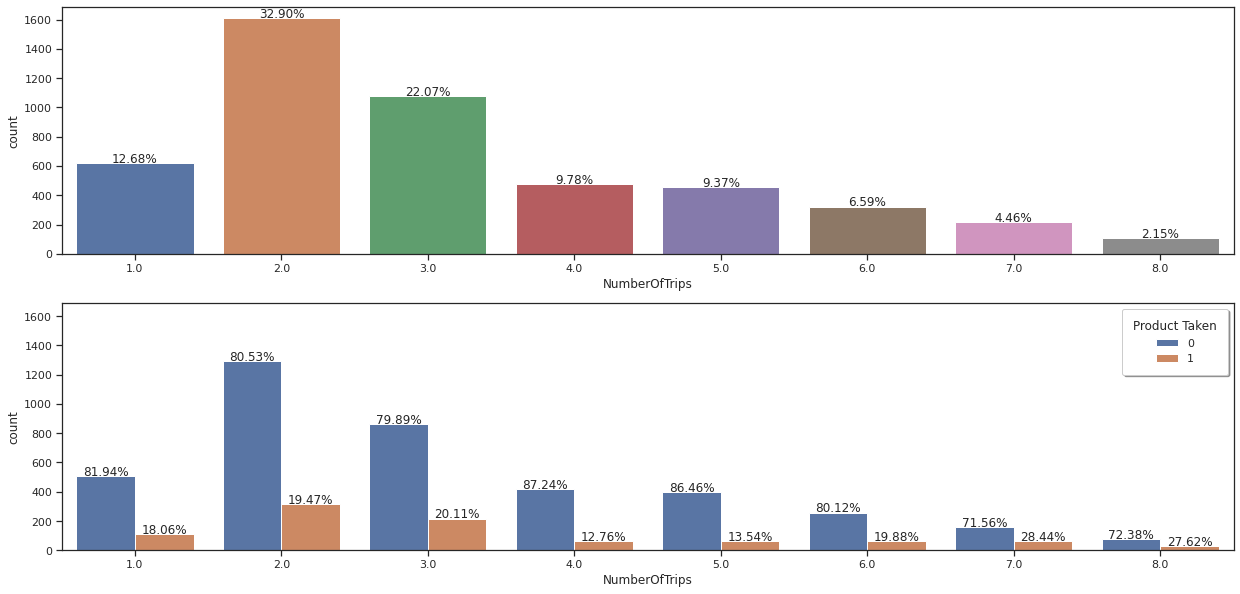

In [73]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph) - after treating the outliers
percentage_on_bar(data['NumberOfTrips'], hue = data['ProdTaken'])

- More frequent 'NumberOfTrips' on category 2 (32.9%) followed by category 3 (22.07%). Categories 7 and 8 with higher percentage of products taken (28.44% and 27.62%, respectively) when compared to the other categories.
- The missing values for 'NumberOfTrips' were treated with a Mode Imputation.
- The assumed outlier categories 19, 20, 21 and 22 represented less than 0.1% of the data entries, and were also treated with Mode Imputation.

##### Univariate & Bivariate Analysis for 'PitchSatisfactionScore'

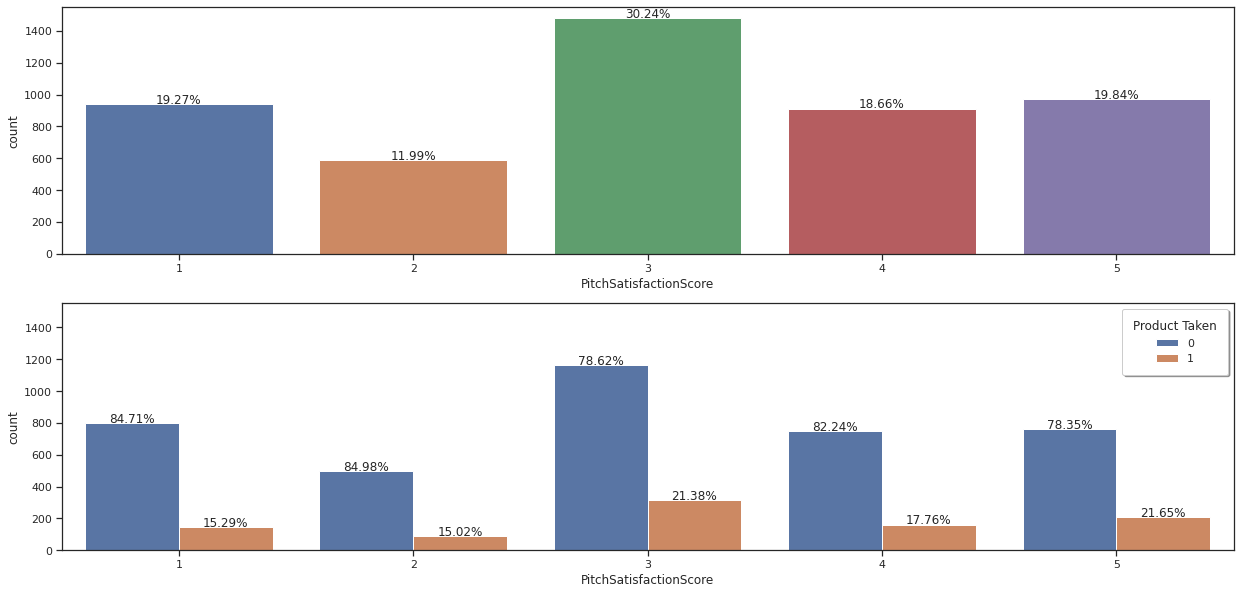

In [74]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['PitchSatisfactionScore'], hue = data['ProdTaken'])

- More frequent 'PitchSatisfactionScore' of 3 (30.24%). Categories 3 and 5 with a higher percentage of products taken (21.38% and 21.65%, respectively) when compared to the other categories.

##### Univariate & Bivariate Analysis for 'NumberOfChildrenVisited'

In [75]:
# Checking Missing values for 'NumberOfChildrenVisited' before the Imputations
data[['NumberOfChildrenVisited']].isnull().sum()

NumberOfChildrenVisited    66
dtype: int64

In [76]:
# Treating missing values with the Mode Imputation for 'NumberOfChildrenVisited'
data['NumberOfChildrenVisited'].fillna(value =  data['NumberOfChildrenVisited'].mode()[0], inplace = True)

In [77]:
# Checking Missing values for 'NumberOfChildrenVisited' after the Imputations
data[['NumberOfChildrenVisited']].isnull().sum()

NumberOfChildrenVisited    0
dtype: int64

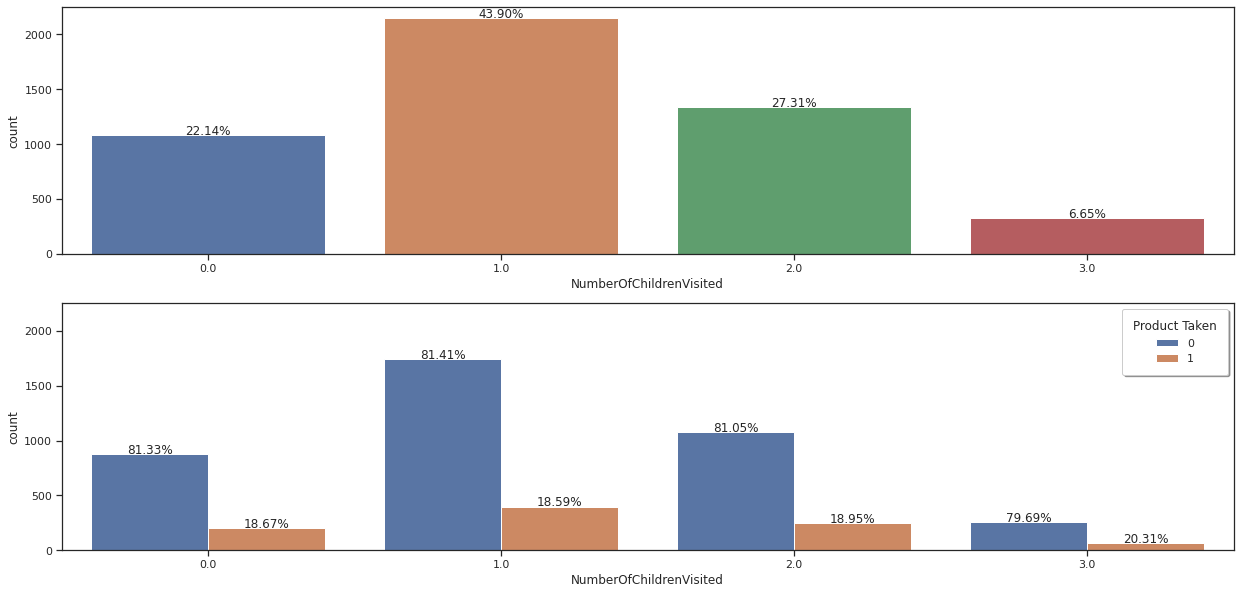

In [78]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['NumberOfChildrenVisited'], hue = data['ProdTaken'])

- More frequent 'NumberOfChildrenVisited' on category 1 (43.90%). All categories presented approximate similar percentages of products taken (range from 18.6% to 20.3%).
- The missing values for 'NumberOfChildrenVisited' were treated with a Mode Imputation.

#### Univariate & Bivariate Analysis for Categorical/Ordinal/Boolean Variables - 'ProdTaken', 'Passport' and 'OwnCar'

In [79]:
# Checking Number of Null Values Categorical/Ordinal/Boolean Variables
data[['ProdTaken', 'Passport', 'OwnCar']].isnull().sum()

ProdTaken    0
Passport     0
OwnCar       0
dtype: int64

##### Univariate Analysis for 'ProdTaken'

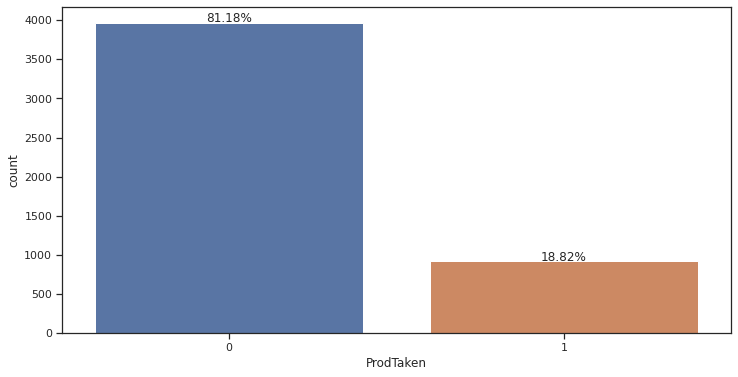

In [80]:
# Countplot with overall Percentages
feature = data['ProdTaken']
sns.set({'figure.figsize': (12, 6)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")
total = len(feature)
ax = sns.countplot(x = feature, data = data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, '{:1.2f}'.format(100 * height / total) + "%", ha = "center")

- 'ProdTaken' is the Dependent Variable and exhibits a high level of imbalance, with only 18.82% of Customers who purchased the travel packages ('ProdTaken = 1').

##### Univariate & Bivariate Analysis for 'Passport'

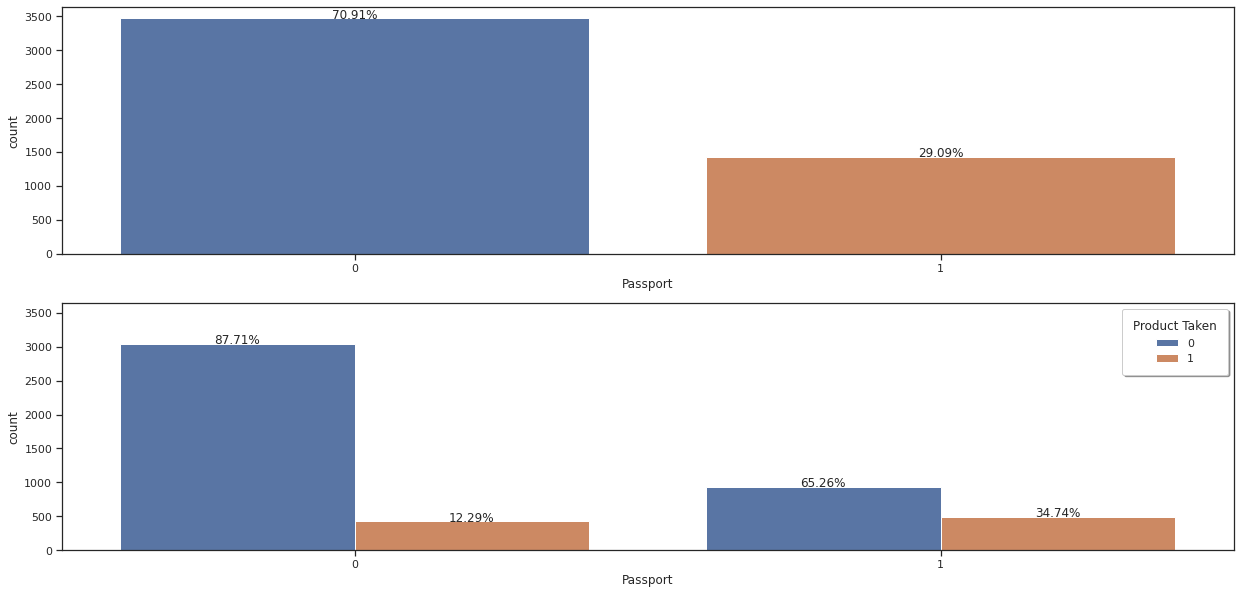

In [81]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['Passport'], hue = data['ProdTaken'])

- For 'Passport', 29.09% of the data falls into category 1. Also, for category 1 there's a considerably higher percentage of products taken (34.74%). This means that Customers who have a passport are more likely to buy travel packages.

##### Univariate & Bivariate Analysis for 'OwnCar'

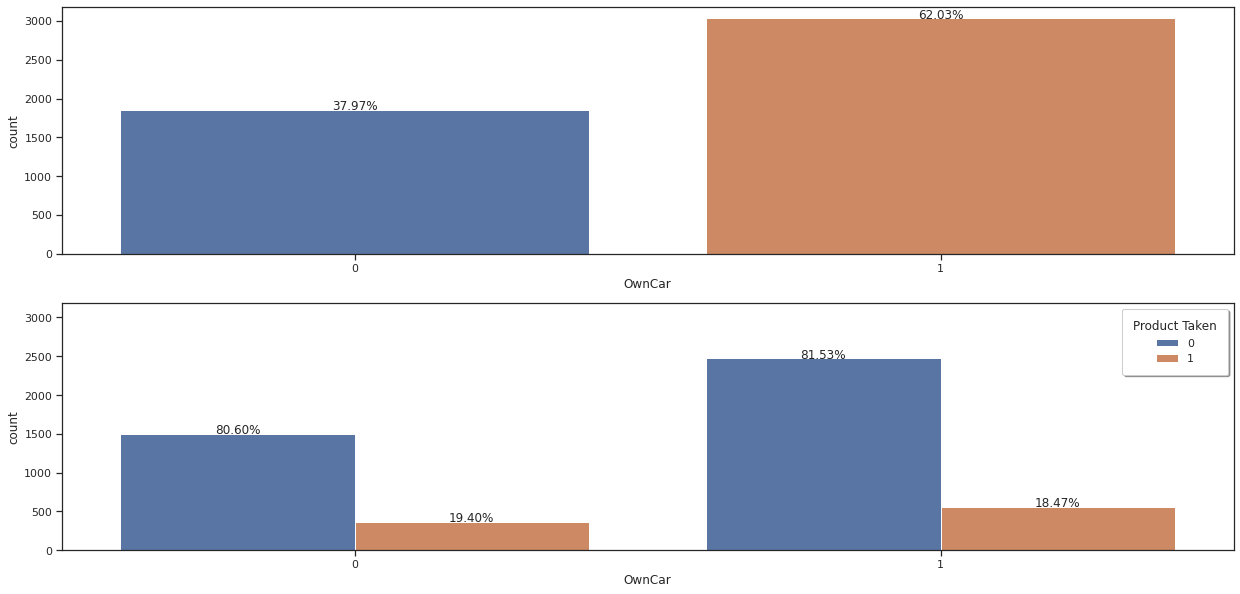

In [82]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['OwnCar'], hue = data['ProdTaken'])

- Most of the Customers have their own car (62.03%). No relevant difference between categories 0 and 1 for the percentages of products taken (range from 18.5% to 19.4%).

#### Univariate & Bivariate Analysis for Categorical/Nominal Variables - 'TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus' and 'Designation'

In [83]:
# Checking Number of Null Values Categorical/Nominal Variables
data[['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']].isnull().sum()

TypeofContact     25
Occupation         0
Gender             0
ProductPitched     0
MaritalStatus      0
Designation        0
dtype: int64

##### Univariate & Bivariate Analysis for 'TypeofContact'

In [84]:
# Checking Missing values for 'TypeofContact' before the Imputations
data[['TypeofContact']].isnull().sum()

TypeofContact    25
dtype: int64

In [85]:
# Treating missing values with the Mode Imputation for 'TypeofContact'
data['TypeofContact'].fillna(value = data['TypeofContact'].mode()[0], inplace = True)

In [86]:
# Checking Missing values for 'TypeofContact' after the Imputations
data[['TypeofContact']].isnull().sum()

TypeofContact    0
dtype: int64

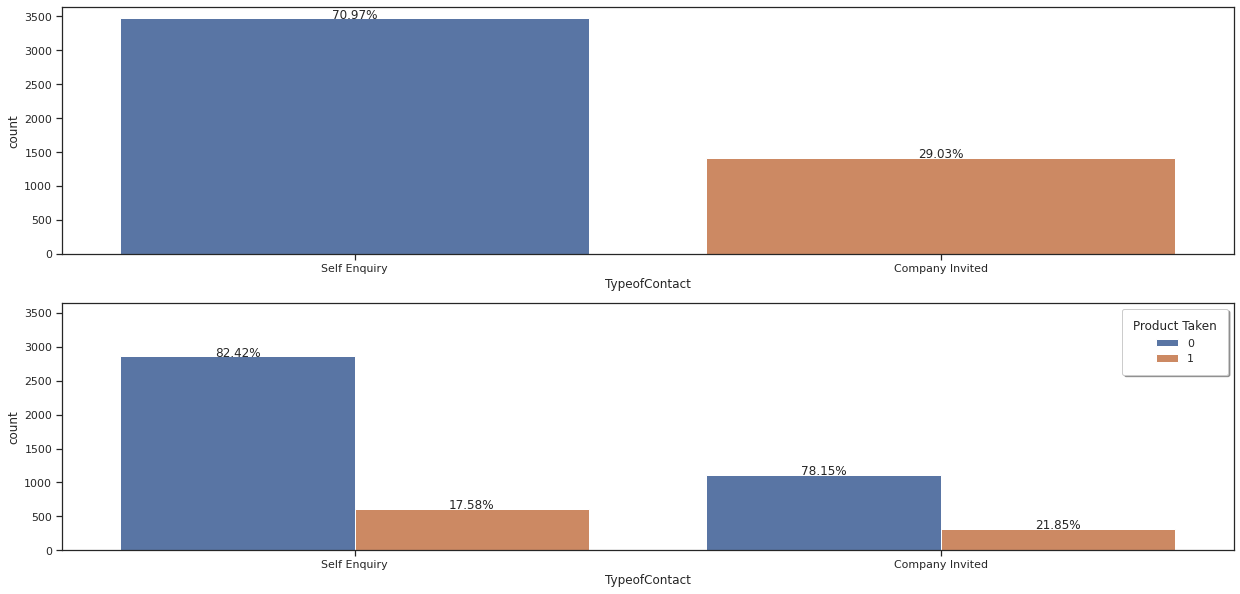

In [87]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['TypeofContact'], hue = data['ProdTaken'])

- For 'TypeofContact', most of the data (70.97%) falls into the 'Self Enquiry' category, however within the category 'Company Invited' there's a slightly higher percentage (21.85%) of products taken when compared to the other categories.
- The missing values for 'TypeofContact' were treated with a Mode Imputation.

##### Univariate & Bivariate Analysis for 'Occupation'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


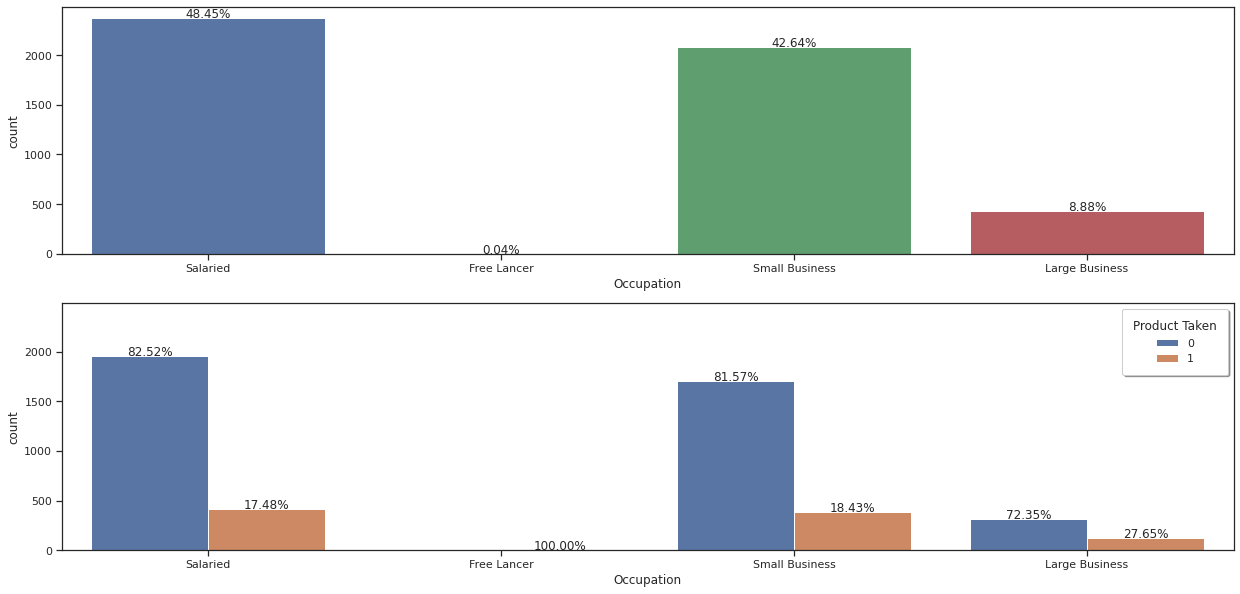

In [88]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['Occupation'], hue = data['ProdTaken'])

- For 'Occupation', most of the data is concentrated within the categories 'Salaried' and 'Small Business' (48.45% and 42.64%, respectively). However, for the category 'Large Business' there is higher percentage (27.65%) of products taken when compared to the other categories. 
- The 'Free Lancer' category is negligible since it only represents 0.04% of the entries in the dataset.

##### Univariate & Bivariate Analysis for 'Gender'

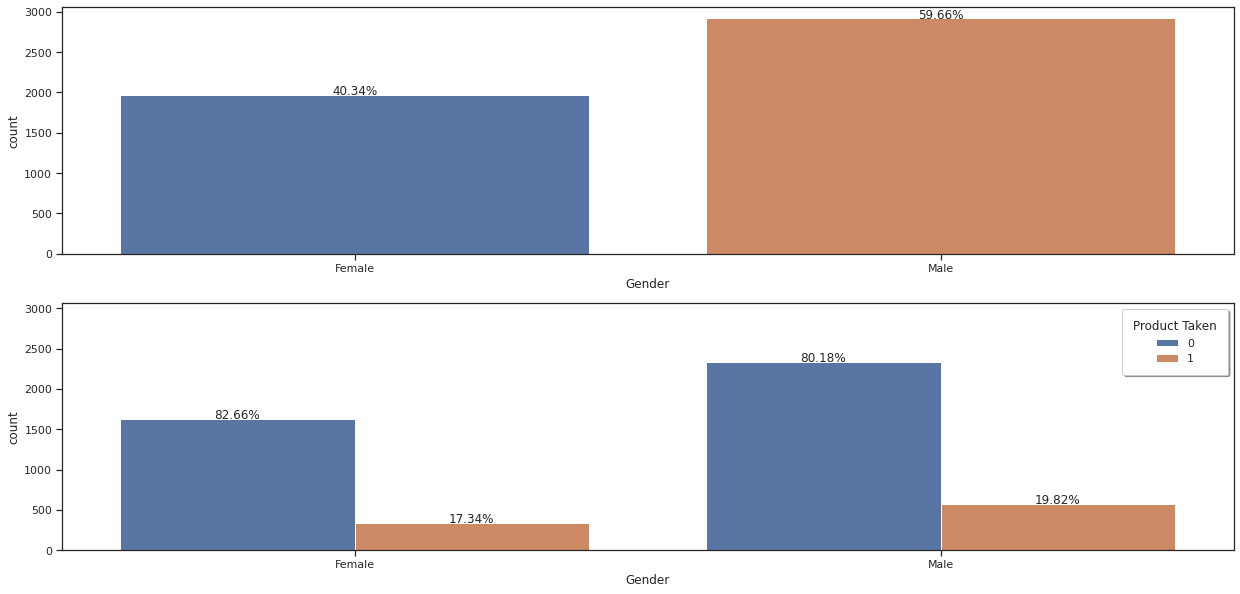

In [89]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['Gender'], hue = data['ProdTaken'])

- Regarding 'Gender', most of the Customers in the dataset are 'Male' (59.66%). There are no distinguishable differences between 'Female' and 'Male' for the percentages of products taken (17.34% and 19.82%, respectively).

##### Univariate & Bivariate Analysis for 'ProductPitched'

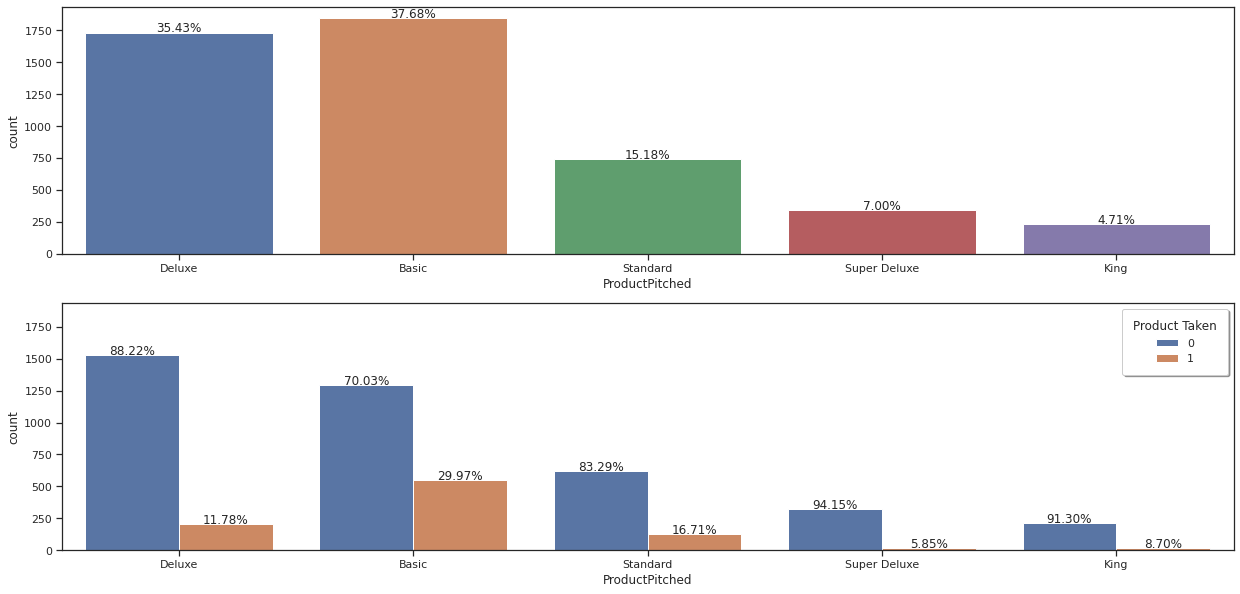

In [90]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['ProductPitched'], hue = data['ProdTaken'])

- For 'ProductPitched', most of the data is concentrated within 'Basic' and 'Deluxe' categories (37.68% and 35.43%, respectively). The 'Basic' package represents a considerably higher percentage of products taken (29.97%) in comparison to the other categories. The 'Super Deluxe' package represents a lower percentage of products taken (5.85%).

##### Univariate & Bivariate Analysis for 'MaritalStatus'

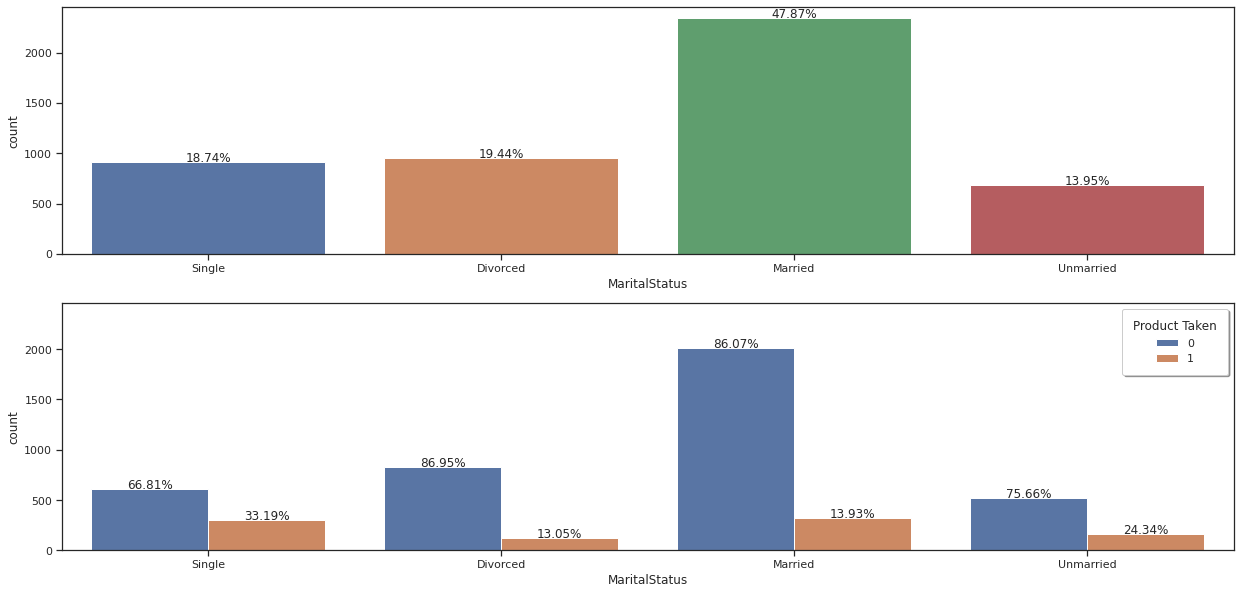

In [91]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['MaritalStatus'], hue = data['ProdTaken'])

- Regarding 'MaritalStatus', most of the Customers in the dataset are 'Married' (47.87%). There are higher percentage of products taken on the categories 'Single' and 'Unmarried' (33.19% and 24.34%, respectively).

##### Univariate & Bivariate Analysis for 'Designation'

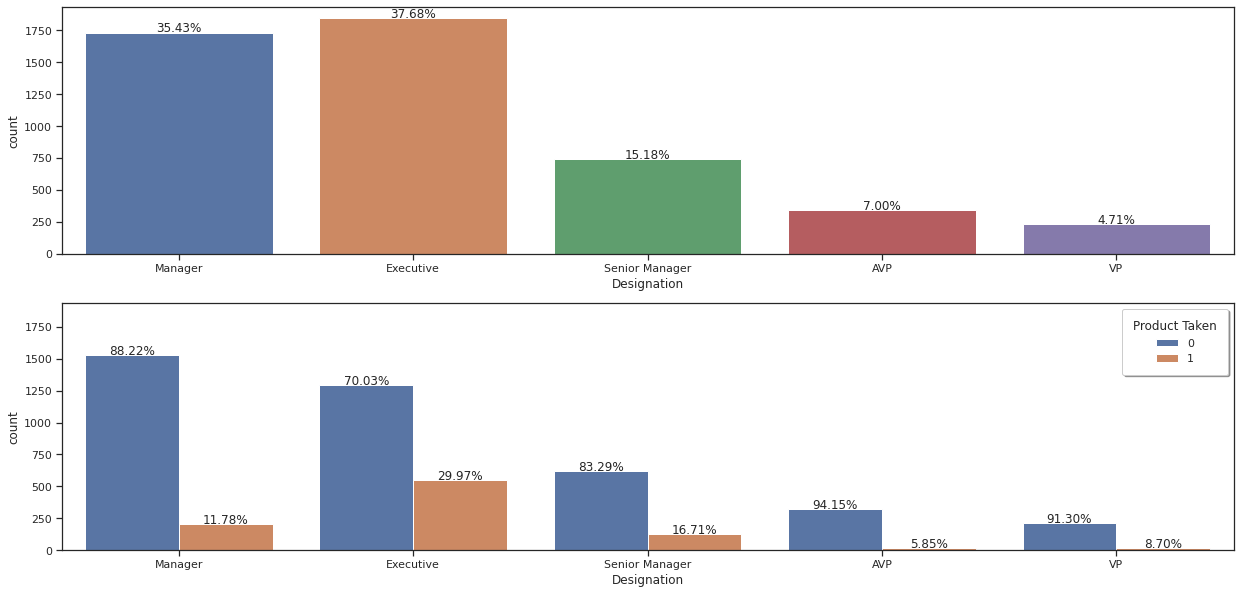

In [92]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'ProductTaken' within each Category (bottom graph)
percentage_on_bar(data['Designation'], hue = data['ProdTaken'])

- For 'Designation', most of the data is concentrated within 'Executive' and 'Manager' categories (37.68% and 35.43%, respectively). The 'Executive' designation represents a considerably higher percentage of products taken (29.97%) in comparison to the other categories.
- It's also important to mention that we got exactly these same trends on 'ProductPitched', or that there's a direct association of 'ProductPitched' and 'Designation'. A more detailed analysis on this will be conducted in the next session.

#### Come up with a Customer Profile (Characteristics of a Customer) of the Different Packages
- Gives out the information on the type of customers who would buy a certain package. The profiles can be on the basis of different features like the average age, average monthly income, etc.

In [93]:
# Customer Related Variables (Subsets)
subset_numeric_continuous = data[['Age', 'MonthlyIncome']]
subset_numeric_discrete = data[['CityTier', 'NumberOfPersonVisited', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisited']]
subset_categorical_boolean = data[['Passport', 'OwnCar']]
subset_categorical_nominal = data[['Occupation','Gender', 'MaritalStatus', 'Designation']]

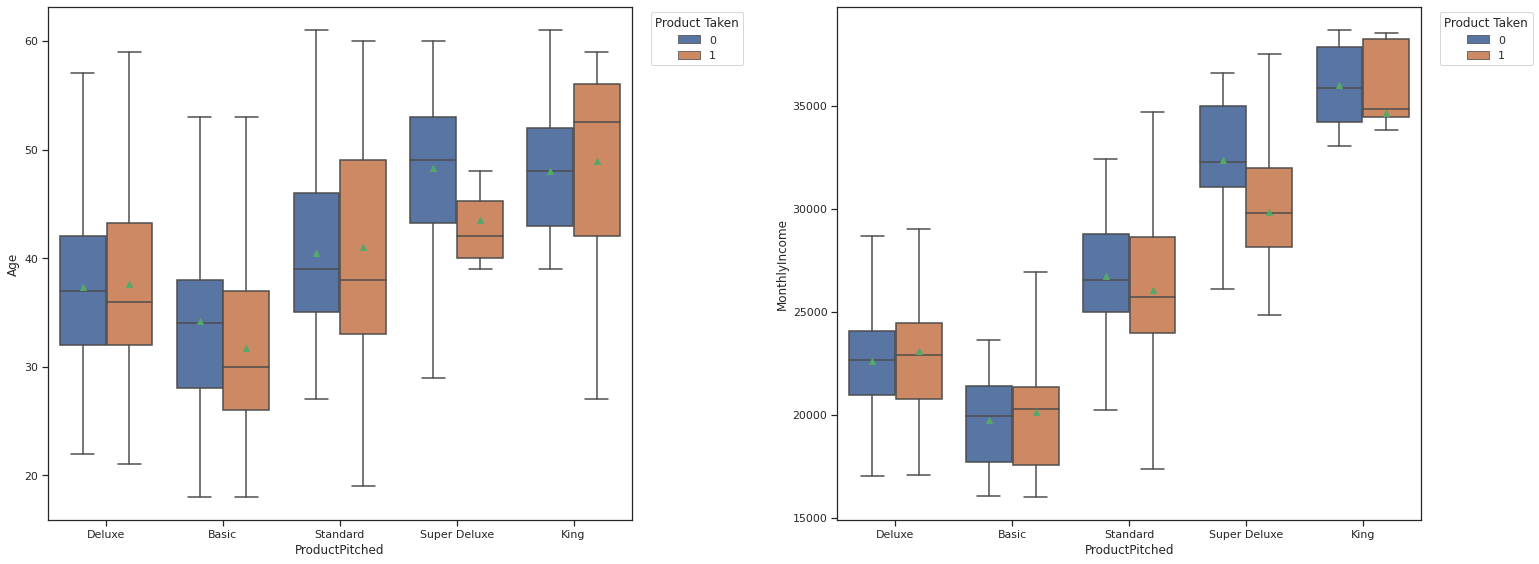

In [94]:
# Combo Boxplot for Numerical/Continuous Variables 
features = subset_numeric_continuous.columns.tolist()
sns.set({'figure.figsize': (20, 8)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")
for i, variable in enumerate(features):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(x = "ProductPitched", y = data[variable], hue = 'ProdTaken', data = data, showfliers = False, showmeans = True)
    plt.tight_layout()
    plt.legend(loc = 'upper right', title = 'Product Taken', bbox_to_anchor=(1.2, 1))

- On average, younger Customers are more likely to explore the 'Basic' packages. In the other hand, older Customers are more likely to explore the 'Super Deluxe' and 'King' packages.
- On average, lower income Customers are more likely to explore the 'Deluxe' and 'Basic' package types. 'Super Deluxe' and 'King' package types are more likely to be explored by Customers with higher income. 

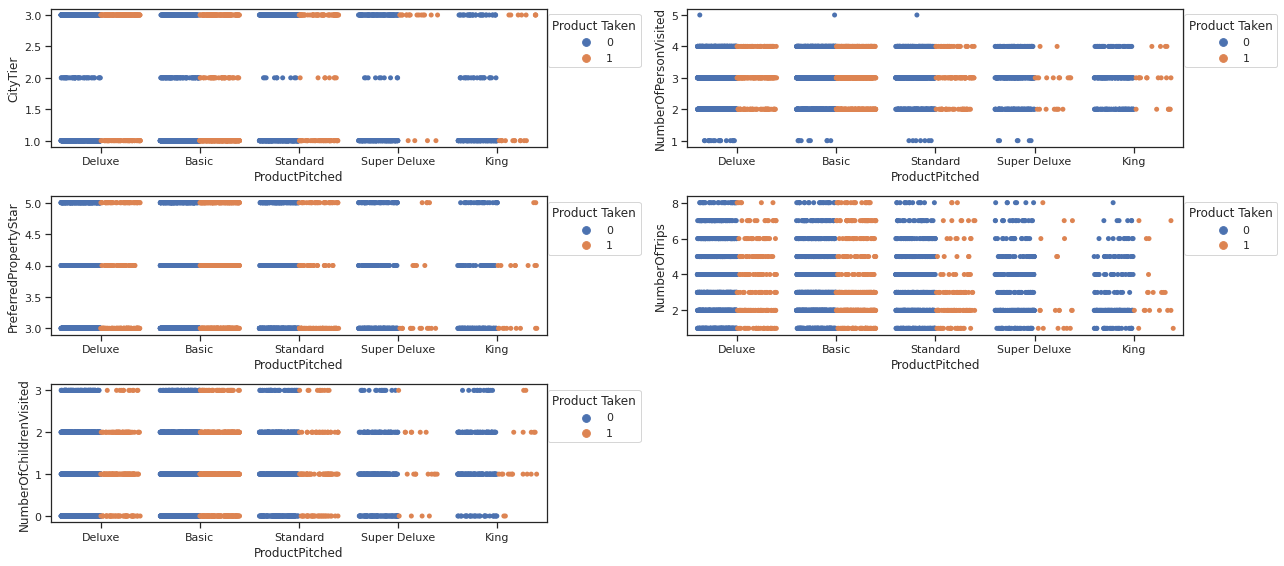

In [95]:
# Combo Stripplot for Numerical/Discrete Variables 
features = subset_numeric_discrete.columns.tolist()
sns.set({'figure.figsize': (18, 8)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")
for i, variable in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.stripplot(x = "ProductPitched", y = data[variable], hue = 'ProdTaken', dodge = True, jitter = 0.4, data = data)
    plt.tight_layout()
    plt.legend(loc = 'upper right', title = 'Product Taken', bbox_to_anchor=(1.2, 1))

- On 'CityTier' 2, there weren't any products taken for 'Deluxe', 'Super Deluxe' and 'King' package types.
- There were much fewer data entries for visits that the Customer came alone ('NumberOfPersonVisited' = 1), and when that hapenned no travel packages were sold.

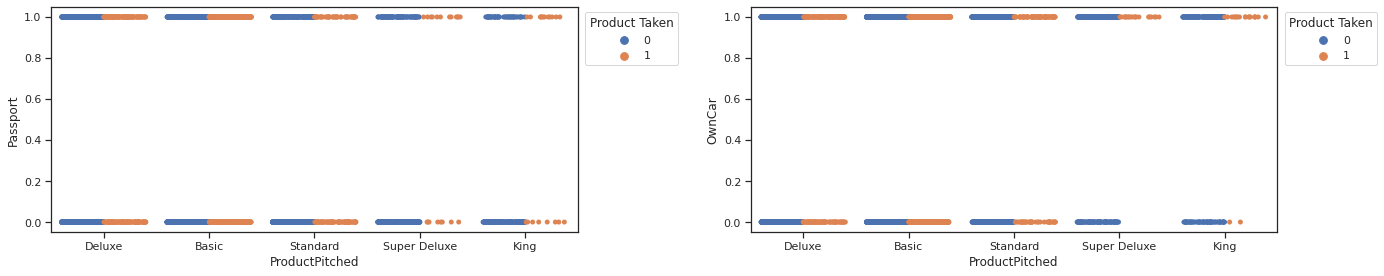

In [96]:
# Combo Boxplot for Categorical/Ordinal/Boolean Variables 
features = subset_categorical_boolean.columns.tolist()
sns.set({'figure.figsize': (18, 4)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")
for i, variable in enumerate(features):
    plt.subplot(1, 2, i + 1)
    sns.stripplot(x = "ProductPitched", y = data[variable], hue = 'ProdTaken', dodge = True, jitter = 0.4, data = data)
    plt.tight_layout()
    plt.legend(loc = 'upper right', title = 'Product Taken', bbox_to_anchor=(1.2, 1))

- Customers who don't own a car are less likely to take the travel packages for 'Super Deluxe' and 'King' categories.

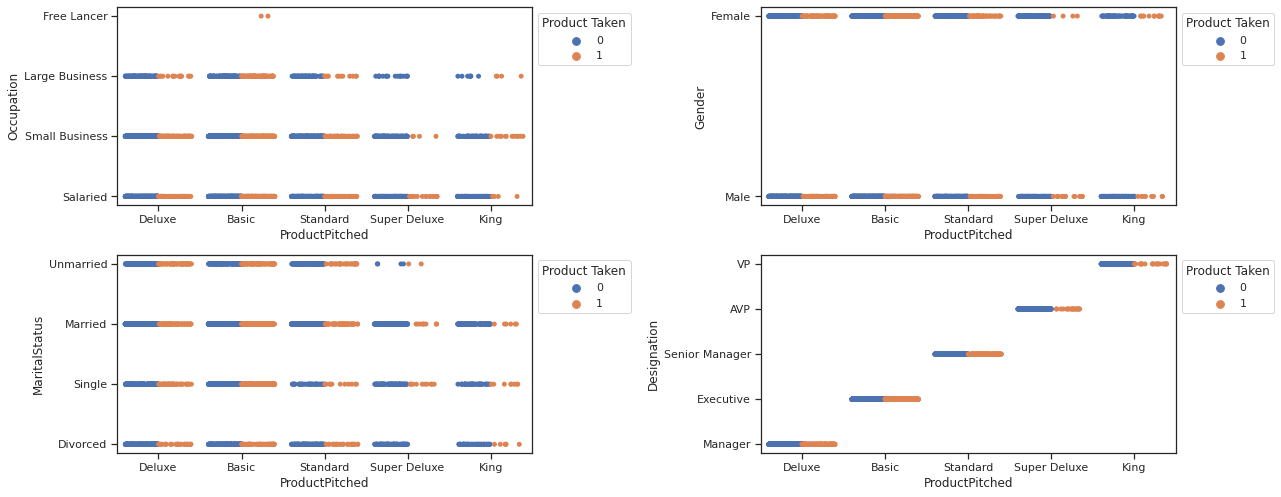

In [97]:
# Combo Boxplot for Categorica/Nominal Variables 
features = subset_categorical_nominal.columns.tolist()
sns.set({'figure.figsize': (18, 10)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")
for i, variable in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.stripplot(x = "ProductPitched", y = data[variable], hue = 'ProdTaken', dodge = True, jitter = 0.4, data = data)
    plt.tight_layout()
    plt.legend(loc = 'upper right', title = 'Product Taken', bbox_to_anchor=(1.25, 1))

- As mentioned before, there's a direct association of 'ProductPitched' and 'Designation'. It's confirmed that a 'Deluxe' package was only associated with 'Managers', a 'Basic' package was only associated with 'Executives', a 'Standard' package was only associated with 'Sr Managers', a 'Super Deluxe' package was only associated with 'AVPs', and a 'King' package was only associated with 'VPs'.
- Because of this strong association between 'ProductPitched' and 'Designation', there's no reason to keep both of them included in the dataset for building a classification model. 'Designation' will be removed from the dataset.

In [98]:
# Dropping 'Designation'
data.drop(columns = ['Designation'], inplace = True)

- The 'Designation' variable was removed from the dataset.

***
## Illustrate the Insights based on EDA <a class="anchor" id="2"></a>

- Key meaningful observations on the relationship between variables

Summary for the key insights from EDA (all graphs and other details are covered in the previous session): 

- 'ProdTaken' is the Dependent Variable and exhibits a high level of imbalance, with only 18.82% of Customers who purchased the travel packages.
    
- 'CityTier' categories 2 and 3 with a higher percentage of products taken (23.23% and 23.60%, respectively) when compared to "CityTier1" with 16.30%.

- 'NumberOfFollowups' categories 5 and 6 with a higher percentage of products taken (24.87% and 39.71%, respectively) when compared to the other categories.

- 'PreferredPropertyStar' category 4 and 5 with a higher percentage of products taken (19.93% and 26.15%, respectively) when compared to category 3 (16.16%).

- 'NumberOfTrips' categories 7 and 8 with a higher percentage of products taken (28.44% and 27.62%, respectively) when compared to the other categories.

- 'PitchSatisfactionScore' categories 3 and 5 with a higher percentage of products taken (21.38% and 21.65%, respectively) when compared to the other categories.

- 'Passport' category 1 with a considerably high percentage of products taken (34.74%). This means that Customers who have a passport are more likely to buy travel packages.

- 'TypeofContact' category 'Company Invited' with a slightly higher percentage (21.85%) of products taken when compared to the other categories.

- 'Occupation' category 'Large Business' with slightly higher percentage (27.65%) of products taken when compared to the other categories. 

- On 'ProductPitched', the 'Basic' package represents a considerably higher percentage of products taken (29.97%) in comparison to the other categories. The 'Super Deluxe' package represents a lower percentage of products taken (5.85%).

- 'MaritalStatus' categories 'Single' and 'Unmarried' with a higher percentage of products taken (33.19% and 24.34%, respectively).

- On average, younger Customers are more likely to explore 'Basic' packages, and older Customers are more likely to explore the 'Super Deluxe' and 'King' packages.
    
- On average, lower income Customers are more likely to explore the 'Deluxe' and 'Basic' package types. 'Super Deluxe' and 'King' package types are more likely to be explored by Customers with higher income.

***
## Data Pre-processing <a class="anchor" id="3"></a>

- Prepare the data for analysis - Missing value Treatment, Outlier Detection(treat, if needed- why or why not ), Feature Engineering, Prepare data for modeling

In [99]:
# Checking Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ProdTaken                4888 non-null   int64  
 1   Age                      4888 non-null   float64
 2   TypeofContact            4888 non-null   object 
 3   CityTier                 4888 non-null   int64  
 4   DurationOfPitch          4888 non-null   float64
 5   Occupation               4888 non-null   object 
 6   Gender                   4888 non-null   object 
 7   NumberOfPersonVisited    4888 non-null   int64  
 8   NumberOfFollowups        4888 non-null   float64
 9   ProductPitched           4888 non-null   object 
 10  PreferredPropertyStar    4888 non-null   float64
 11  MaritalStatus            4888 non-null   object 
 12  NumberOfTrips            4888 non-null   float64
 13  Passport                 4888 non-null   int64  
 14  PitchSatisfactionScore  

In [100]:
# Check Unique Categories for Numerical/Dicrete, Categorical/Ordinal/Boolean and Categorical/Nominal Independent Variables
cat_cols = ['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'NumberOfPersonVisited', 'NumberOfFollowups', 'ProductPitched',\
            'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisited']
for column in cat_cols :
    print(data[column].value_counts(normalize = False))
    print()
    print('-'*30)

Self Enquiry       3469
Company Invited    1419
Name: TypeofContact, dtype: int64

------------------------------
1    3190
3    1500
2     198
Name: CityTier, dtype: int64

------------------------------
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64

------------------------------
Male      2916
Female    1972
Name: Gender, dtype: int64

------------------------------
3    2402
2    1418
4    1026
1      39
5       3
Name: NumberOfPersonVisited, dtype: int64

------------------------------
4.0    2113
3.0    1466
5.0     768
2.0     229
1.0     176
6.0     136
Name: NumberOfFollowups, dtype: int64

------------------------------
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64

------------------------------
3.0    3019
5.0     956
4.0     913
Name: PreferredPropertyStar, dtype: int64

------------------------------
Mar

- All missed values and assumed outliers were previously treated. The dataset preserved its original number of rows (4888), and the missed values were treated either with mean, median or mode imputations. Also, outliers were treated using different techniques such as: mean imputation for a given category, mode imputation or replacement with the whisker values.

In [101]:
# Categorical/Nominal Variables selection for One-hot Enconding
oneHotCols = ["TypeofContact", "Occupation", "Gender", "MaritalStatus", "ProductPitched"]

In [102]:
# For the final data pre-procesing on the Categorical/Nominal Variables using One-hot Enconding the first category won't be dropped (drop_first = False).
# If dropping the first category, it may break the symmetry of the original representation and can therefore induce a bias in downstream models.
data = pd.get_dummies(data, columns = oneHotCols, drop_first = False)

In [103]:
# Checking Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ProdTaken                      4888 non-null   int64  
 1   Age                            4888 non-null   float64
 2   CityTier                       4888 non-null   int64  
 3   DurationOfPitch                4888 non-null   float64
 4   NumberOfPersonVisited          4888 non-null   int64  
 5   NumberOfFollowups              4888 non-null   float64
 6   PreferredPropertyStar          4888 non-null   float64
 7   NumberOfTrips                  4888 non-null   float64
 8   Passport                       4888 non-null   int64  
 9   PitchSatisfactionScore         4888 non-null   int64  
 10  OwnCar                         4888 non-null   int64  
 11  NumberOfChildrenVisited        4888 non-null   float64
 12  MonthlyIncome                  4888 non-null   f

- After applying One-hot Enconding on the Categorical/Nominal variables, all variables in the resulting dataset are now numerical.
- 29 independent variables will be utilized to build the different Classifiers along the next sessions.

In [104]:
# Creating an array for the independent variables (X) and a list for the dependent variable (y)
X = data.drop(['ProdTaken'], axis = 1)
y = data['ProdTaken']

In [105]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1, stratify = y)

In [106]:
# Resulting Split into Training and Test Set (70:30 Ratio)
print("Original    : {0} ({1:0.2f}%)".format(len(data.loc[data['ProdTaken'] == 1]), (len(data.loc[data['ProdTaken'] == 1])/len(data.index)) * 100))
print("Original    : {0} ({1:0.2f}%)".format(len(data.loc[data['ProdTaken'] == 0]), (len(data.loc[data['ProdTaken'] == 0])/len(data.index)) * 100))
print("")
print("Training    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))

Original    : 920 (18.82%)
Original    : 3968 (81.18%)

Training    : 644 (18.82%)
Training    : 2777 (81.18%)

Test        : 276 (18.81%)
Test        : 1191 (81.19%)


- Train and test splits were created with 70% and 30% of the data, respectively.
- For the data splitting, a 'stratify = y' argument was utilized to create the splits in a stratified fashion (as seen on the summary above).

***
- Based on the Background and Context:
    
    "... the marketing cost was quite high because customers were contacted at random without looking at the available information."
    
    "... build a model to predict the potential Customer who is going to purchase the newly introduced package."
    
- More information regarding marketing costs vs. cost of a lost Customer would be required to select the best metric for the Classification model when performing tuning.
    
- If we prioritize Recall, there'll be more emphasis on reducing the amount of false negatives, and that'd reduce the chance to miss a Customer who's willing to buy the travel package. However, that'll create a direct impact in increasing the amount of false positives (will reduce Precision), and consequently turn the marketing expenditure less efficient (more random calls to Customers who are not willing to buy the product). The opposite of that would happen if we priotitize Precision.

- Assuming equal importance for Recall and Precision, a F1-Score metric (which represents a balance between Recall and Precision) will be utilized as the objective for model tuning.

***
## Model building - Bagging <a class="anchor" id="4"></a>

- Build bagging classifier, random forest and decision tree.

#### Decision Tree Classifier with Default Parameters

In [107]:
decision_tree_original = DecisionTreeClassifier(random_state = 1)
decision_tree_original .fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

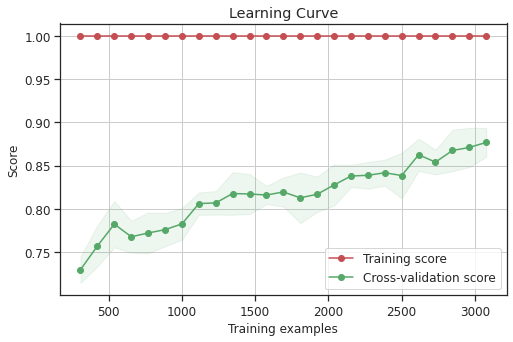

In [108]:
# A learning curve shows the validation and training score of an estimator for varying numbers of training samples.
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
skplt.estimators.plot_learning_curve(decision_tree_original, X_train, y_train, scoring = 'accuracy', cv = 10, train_sizes = np.linspace(.1, 1.0, 25), figsize = (8,5));

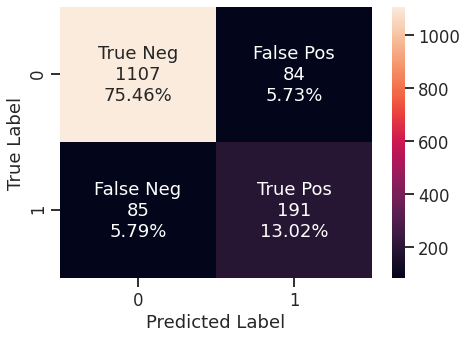

In [109]:
# Creating the Confusion Matrix for the Decision Tree Classifier with Default Parameters
make_confusion_matrix(decision_tree_original , y_test)

In [110]:
# Metrics on Train and Test Sets
decision_tree_original_metrics = get_metrics_score(decision_tree_original)

Train Accuracy = 1.0
Test Accuracy = 0.885
Train Recall = 1.0
Test Recall = 0.692
Train Precision = 1.0
Test Precision = 0.695
Train F1 Score: 1.0
Test F1 Score: 0.693
ROC AUC Score: 0.811


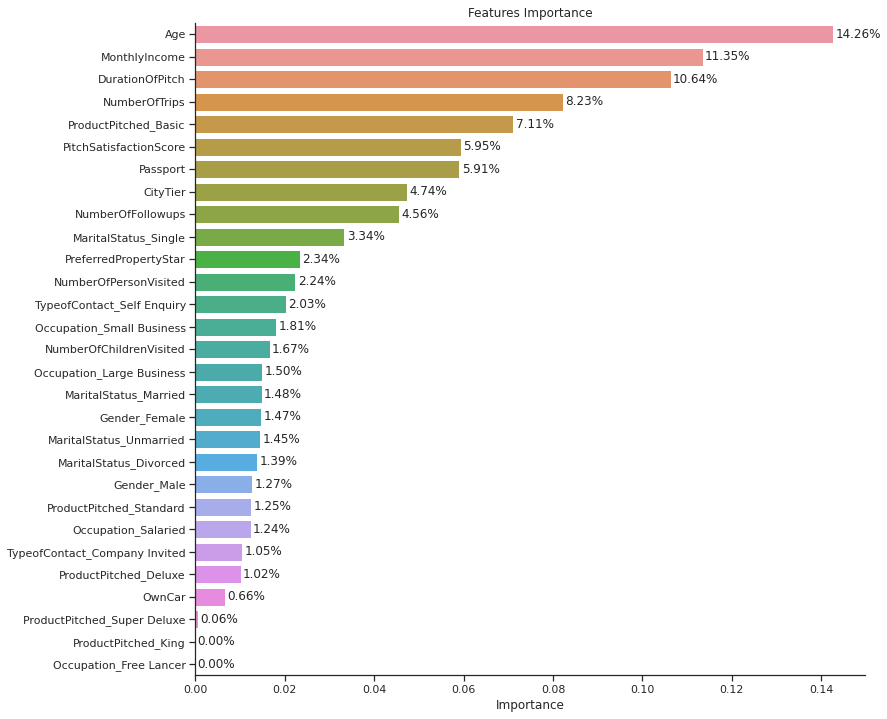

In [111]:
# Features Importance
features_importance(decision_tree_original)

- Results for the DecisionTreeClassifier with default parameters:
    
    Train Accuracy = 1.0, Test Accuracy = 0.885 | Train F1 Score: 1.0, Test F1 Score: 0.693
    
- Both Train Set and Test Set Accuracies are relatively close, and that might not represent an overfitting problem.

- the Test Set F1 Score of 0.693 will be used as a reference to compare with the subsequent models.

- Most Important Features (top 05) are: 'Age', 'MonthlyIncome', 'DurationOfPitch', 'Number of Trips' and 'ProductPitched_Basic'.

#### Bagging Classifier with Default Parameters

In [112]:
bagging_original = BaggingClassifier(random_state = 1)
bagging_original.fit(X_train, y_train)

BaggingClassifier(random_state=1)

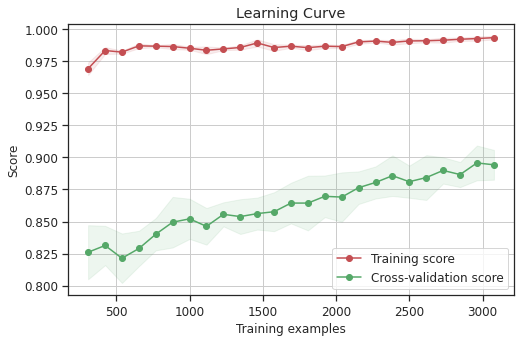

In [113]:
# A learning curve shows the validation and training score of an estimator for varying numbers of training samples.
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
skplt.estimators.plot_learning_curve(bagging_original, X_train, y_train, scoring = 'accuracy', cv = 10, train_sizes = np.linspace(.1, 1.0, 25), figsize = (8,5));

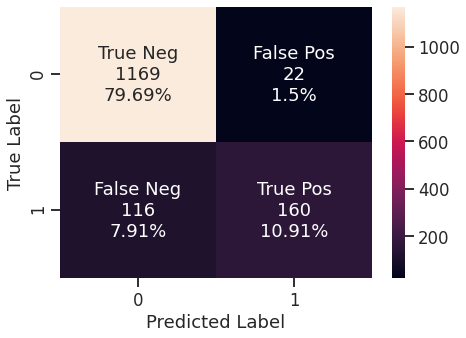

In [114]:
# Creating the Confusion Matrix for the Bagging Classifier with Default Parameters
make_confusion_matrix(bagging_original, y_test)

In [115]:
# Metrics on Train and Test Sets
bagging_original_metrics = get_metrics_score(bagging_original)

Train Accuracy = 0.994
Test Accuracy = 0.906
Train Recall = 0.97
Test Recall = 0.58
Train Precision = 0.995
Test Precision = 0.879
Train F1 Score: 0.983
Test F1 Score: 0.699
ROC AUC Score: 0.93


- Results for the BaggingClassifier with default parameters:
    
    Train Accuracy = 0.994, Test Accuracy = 0.906 | Train F1 Score: 0.983, Test F1 Score: 0.699
    
- Both Train Set and Test Set Accuracies are close, not representing an overfitting problem.

- Test Set F1 Score of 0.699 is almost the same as the score from the DecisionTreeClassifier (0.693). 

#### Random Forest Classifier with Default Parameters

In [116]:
random_forest_original = RandomForestClassifier(random_state = 1)
random_forest_original.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

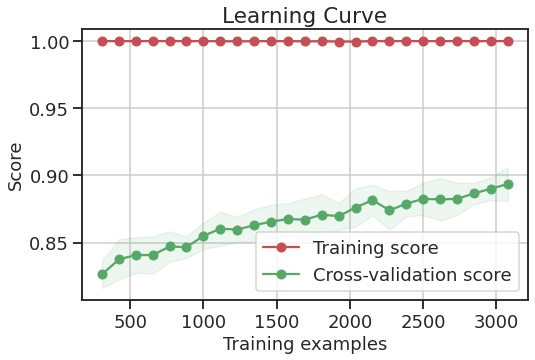

In [117]:
# A learning curve shows the validation and training score of an estimator for varying numbers of training samples.
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
skplt.estimators.plot_learning_curve(random_forest_original, X_train, y_train, scoring = 'accuracy', cv = 10, train_sizes = np.linspace(.1, 1.0, 25), figsize = (8,5));

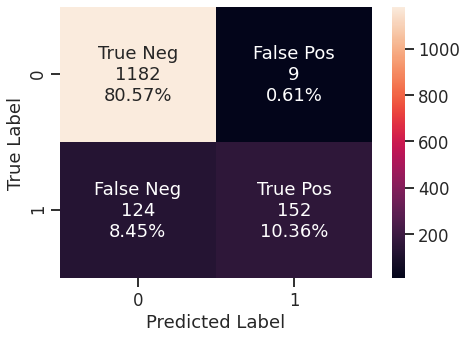

In [118]:
# Creating the Confusion Matrix for the Random Forest Classifier with Default Parameters
make_confusion_matrix(random_forest_original, y_test)

In [119]:
# Recall on train and test
random_forest_original_metrics = get_metrics_score(random_forest_original)

Train Accuracy = 1.0
Test Accuracy = 0.909
Train Recall = 1.0
Test Recall = 0.551
Train Precision = 1.0
Test Precision = 0.944
Train F1 Score: 1.0
Test F1 Score: 0.696
ROC AUC Score: 0.968


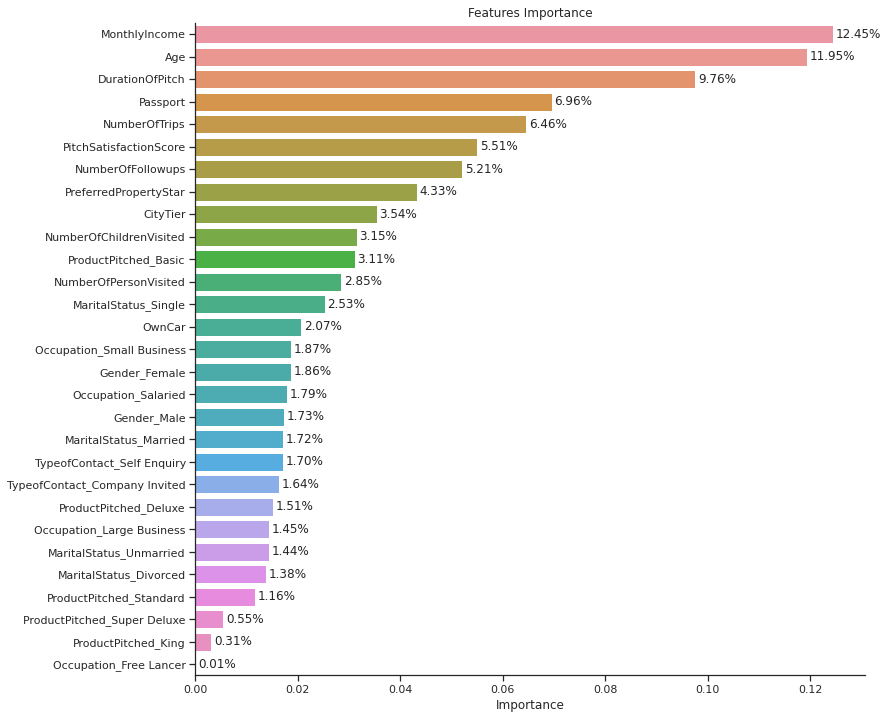

In [120]:
# Features Importance
features_importance(random_forest_original)

- Results for the RandomForestClassifier with default parameters:
    
    Train Accuracy = 1.0, Test Accuracy = 0.909 | Train F1 Score: 1.0, Test F1 Score: 0.696
    
- Both Train Set and Test Set Accuracies are close, not representing an overfitting problem.

- Test Set F1 Score of 0.696 is almost the same as the score from the BaggingClassifier with default parameters (0.699) and DecisionTreeClassifier with default parameters (0.693). 
    
- Most Important Features (top 05) are: 'MonthlyIncome', 'Age', 'DurationOfPitch', 'Passport' and 'Number of Trips'.

***
## Model Performance Evaluation and Improvement - Bagging <a class="anchor" id="5"></a>

- Comment on which metric is right for model performance evaluation and why? - Comment on model performance - Can model performance be improved? check and comment

#### Decision Tree Classifier with Hyperparameters Tuning

In [121]:
decision_tree_tuned = DecisionTreeClassifier(random_state = 1)

# Grid of parameters to choose from
parameters = {'class_weight' : [None, {0:0.20, 1:0.80}],
              'max_depth' : np.arange(1, 5),
              'criterion' : ['entropy','gini'],
              'splitter' : ['best','random'],
              'min_samples_leaf' : [1, 2, 5, 7, 10, 15, 20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease' : [0.0001, 0.001, 0.01]}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(decision_tree_tuned, parameters, scoring = acc_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
decision_tree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
decision_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=4,
                       max_leaf_nodes=10, min_impurity_decrease=0.0001,
                       random_state=1, splitter='random')

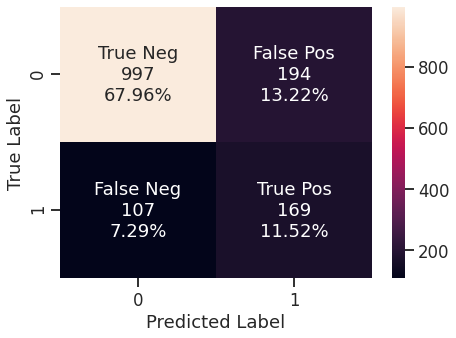

In [122]:
# Creating the Confusion Matrix for the Decision Tree Classifier with Hyperparameters Tuning
make_confusion_matrix(decision_tree_tuned, y_test)

In [123]:
# Metrics on Train and Test Sets
decision_tree_tuned_metrics = get_metrics_score(decision_tree_tuned)

Train Accuracy = 0.792
Test Accuracy = 0.795
Train Recall = 0.579
Test Recall = 0.612
Train Precision = 0.458
Test Precision = 0.466
Train F1 Score: 0.512
Test F1 Score: 0.529
ROC AUC Score: 0.766


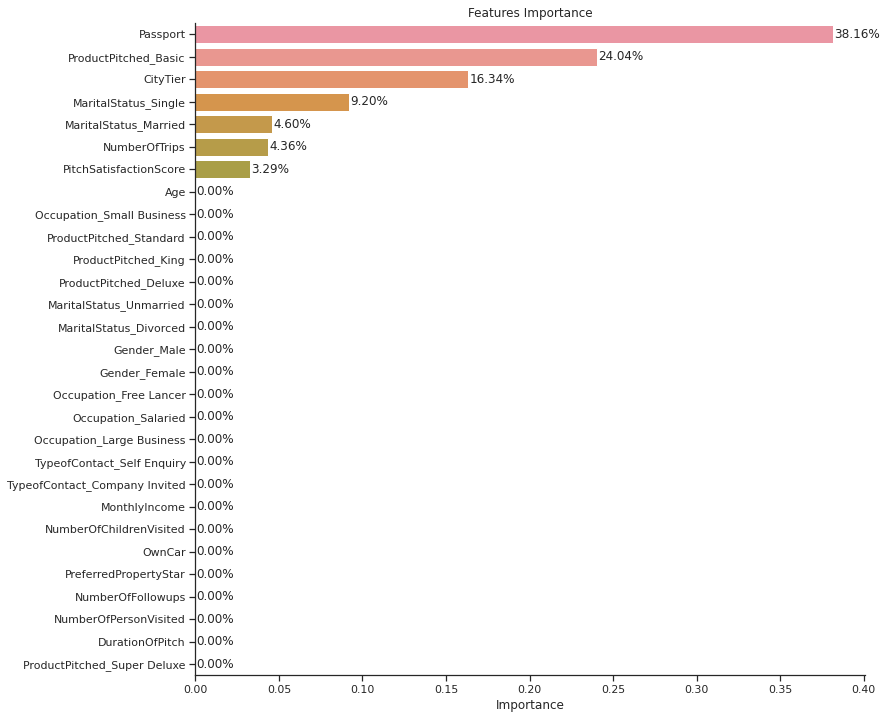

In [124]:
# Features Importance
features_importance(decision_tree_tuned)

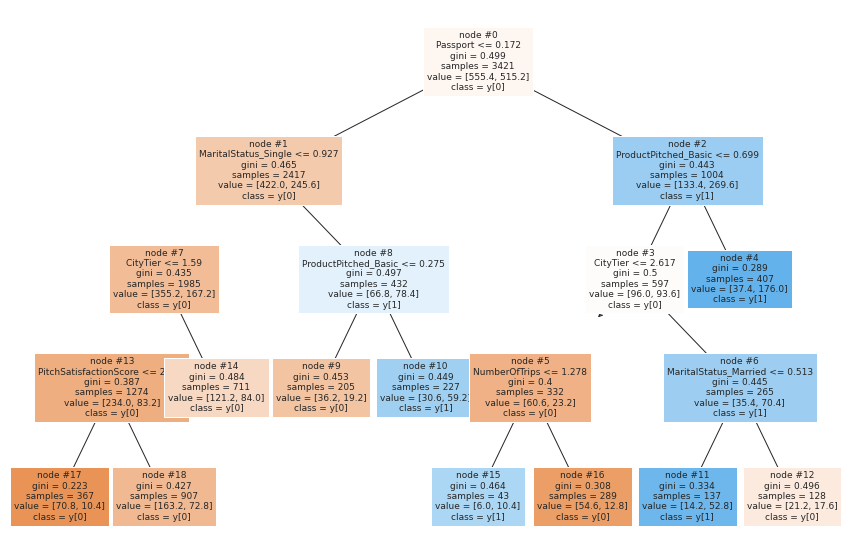

In [125]:
# Visualizing the Decision Tree
feature_names = list(X.columns)
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree_tuned, feature_names = feature_names, filled = True, fontsize = 9, node_ids = True, class_names = True)
plt.show()

In [126]:
# Text Report Showing the Rules of the Tuned Decision Tree
print(tree.export_text(decision_tree_tuned, feature_names = feature_names, show_weights = True))

|--- Passport <= 0.17
|   |--- MaritalStatus_Single <= 0.93
|   |   |--- CityTier <= 1.59
|   |   |   |--- PitchSatisfactionScore <= 2.35
|   |   |   |   |--- weights: [70.80, 10.40] class: 0
|   |   |   |--- PitchSatisfactionScore >  2.35
|   |   |   |   |--- weights: [163.20, 72.80] class: 0
|   |   |--- CityTier >  1.59
|   |   |   |--- weights: [121.20, 84.00] class: 0
|   |--- MaritalStatus_Single >  0.93
|   |   |--- ProductPitched_Basic <= 0.27
|   |   |   |--- weights: [36.20, 19.20] class: 0
|   |   |--- ProductPitched_Basic >  0.27
|   |   |   |--- weights: [30.60, 59.20] class: 1
|--- Passport >  0.17
|   |--- ProductPitched_Basic <= 0.70
|   |   |--- CityTier <= 2.62
|   |   |   |--- NumberOfTrips <= 1.28
|   |   |   |   |--- weights: [6.00, 10.40] class: 1
|   |   |   |--- NumberOfTrips >  1.28
|   |   |   |   |--- weights: [54.60, 12.80] class: 0
|   |   |--- CityTier >  2.62
|   |   |   |--- MaritalStatus_Married <= 0.51
|   |   |   |   |--- weights: [14.20, 52.80] class

- A F1-Score metric was utilized as the objective for model tuning.

- Results for the DecisionTreeClassifier with hyperparameters tuning:
    
    Train Accuracy = 0.792, Test Accuracy = 0.795 | Train F1 Score: 0.512, Test F1 Score: 0.529
    
- Model is possibly underfitting since the Train Set Accuracy got much worse (0.792). 

- On the Test Set, the F1-Score (0.512) is not good enough, and it's considerably lower compared to the previous models.

- Most Important Features (top 05) are: 'Passport', 'ProductPitched_Basic', 'CityTier', 'MaritalStatus_Single' and 'MaritalStatus_Married'

#### Bagging Classifier with Hyperparameters Tuning

In [ ]:
bagging_tuned = BaggingClassifier(random_state = 1)

dtc = DecisionTreeClassifier(random_state = 1)
lr = LogisticRegression(random_state = 1)

# Grid of parameters to choose from
parameters = {'base_estimator' : [dtc, lr],
              'max_samples': [0.7, 0.8, 0.9],
              'max_features': [0.7, 0.8, 0.9],
              'n_estimators' : [25, 35, 45]}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_tuned , parameters, scoring = acc_scorer, cv = 5, verbose = 20)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_tuned  = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_tuned .fit(X_train, y_train)

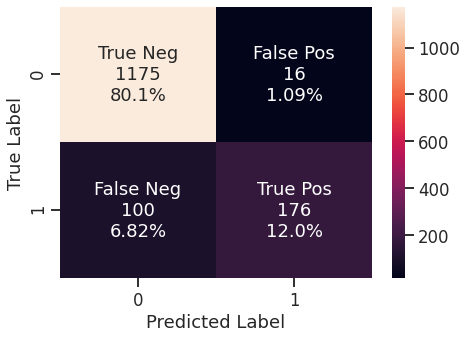

In [128]:
# Creating the Confusion Matrix for the Bagging Classifier with Hyperparameters Tuning
make_confusion_matrix(bagging_tuned, y_test)

In [129]:
# Metrics on Train and Test Sets
bagging_tuned_metrics = get_metrics_score(bagging_tuned)

Train Accuracy = 1.0
Test Accuracy = 0.921
Train Recall = 1.0
Test Recall = 0.638
Train Precision = 1.0
Test Precision = 0.917
Train F1 Score: 1.0
Test F1 Score: 0.752
ROC AUC Score: 0.954


- A F1-Score metric was utilized as the objective for model tuning.

- Results for the BaggingClassifier with Hyperparameters Tuning:
    
    Train Accuracy = 1.0, Test Accuracy = 0.921 | Train F1 Score: 1.0, Test F1 Score: 0.752
    
- Both Train Set and Test Set Accuracies are very close, not necessarily representing an overfitting problem.

- Test Set F1 Score of 0.752 which is better than the previous models.

#### Random Forest Classifier with Hyperparameters Tuning

In [ ]:
# Choose the type of classifier. 
random_forest_tuned = RandomForestClassifier(random_state = 1, oob_score = True, bootstrap = True)

# Grid of parameters to choose from
parameters = {'class_weight' : [None, {0:0.20, 1:0.80}],
              'max_features': [0.3, 0.6, 0.9],
              'max_samples' : [0.7, 0.8, 0.9],
              'min_samples_leaf' : [2, 4, 6],
              'n_estimators' : [100, 200, 300]}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(random_forest_tuned , parameters, scoring = acc_scorer, cv = 5, verbose = 20)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
random_forest_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
random_forest_tuned.fit(X_train, y_train)

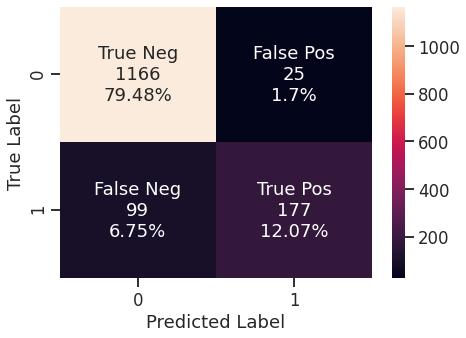

In [131]:
# Creating the Confusion Matrix for the Random Forest Classifier with Hyperparameters Tuning
make_confusion_matrix(random_forest_tuned, y_test)

In [132]:
# Metrics on Train and Test Sets
random_forest_tuned_metrics = get_metrics_score(random_forest_tuned)

Train Accuracy = 0.999
Test Accuracy = 0.915
Train Recall = 0.998
Test Recall = 0.641
Train Precision = 0.994
Test Precision = 0.876
Train F1 Score: 0.996
Test F1 Score: 0.741
ROC AUC Score: 0.964


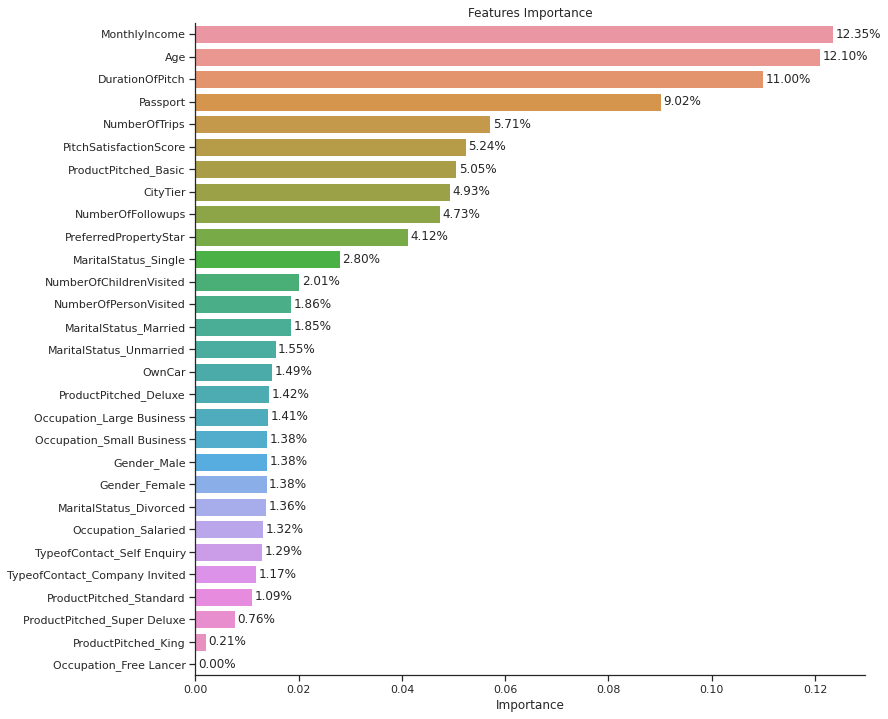

In [133]:
# Features Importance
features_importance(random_forest_tuned)

- A F1-Score metric was utilized as the objective for model tuning.

- Results for the RandomForestClassifier with Hyperparameters Tuning:
    
    Train Accuracy = 0.999, Test Accuracy = 0.915 | Train F1 Score: 0.996, Test F1 Score: 0.741
    
- Both Train Set and Test Set Accuracies are very close, not representing an overfitting problem.

- Test Set F1 Score of 0.741 is slightly lower than the F1 Score for Bagging Classifier with Hyperparameters Tuning (0.752).
    
- Most Important Features (top 05) are: 'MonthlyIncome', 'Age', 'DurationOfPitch', 'Passport', and 'NumberOfTrips'.

***
## Model Building - Boosting <a class="anchor" id="6"></a>

- Build Adaboost, gradient boost, xgboost and stacking classifier

### AdaBoost Classifier with Default Parameters

In [134]:
adaboost_original = AdaBoostClassifier(random_state = 1)
adaboost_original.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

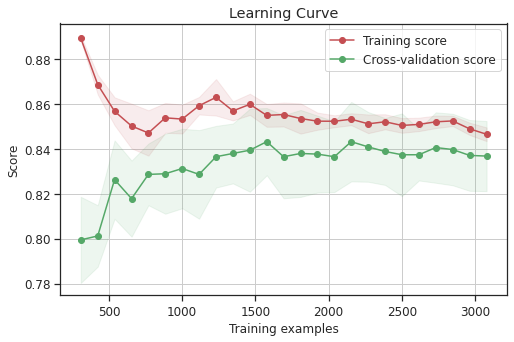

In [135]:
# A learning curve shows the validation and training score of an estimator for varying numbers of training samples.
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
skplt.estimators.plot_learning_curve(adaboost_original, X_train, y_train, scoring = 'accuracy', cv = 10, train_sizes = np.linspace(.1, 1.0, 25), figsize = (8,5));

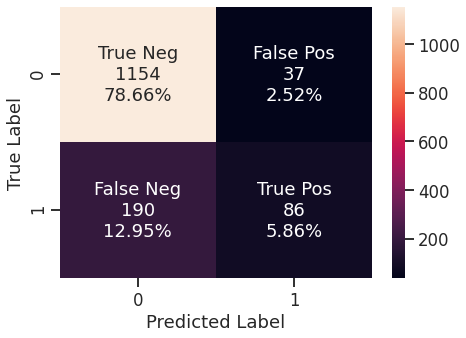

In [136]:
# Creating the Confusion Matrix for AdaBoost Classifier with Default Parameters
make_confusion_matrix(adaboost_original, y_test)

In [137]:
# Metrics on Train and Test Sets
adaboost_original_metrics = get_metrics_score(adaboost_original)

Train Accuracy = 0.846
Test Accuracy = 0.845
Train Recall = 0.312
Test Recall = 0.312
Train Precision = 0.705
Test Precision = 0.699
Train F1 Score: 0.433
Test F1 Score: 0.431
ROC AUC Score: 0.835


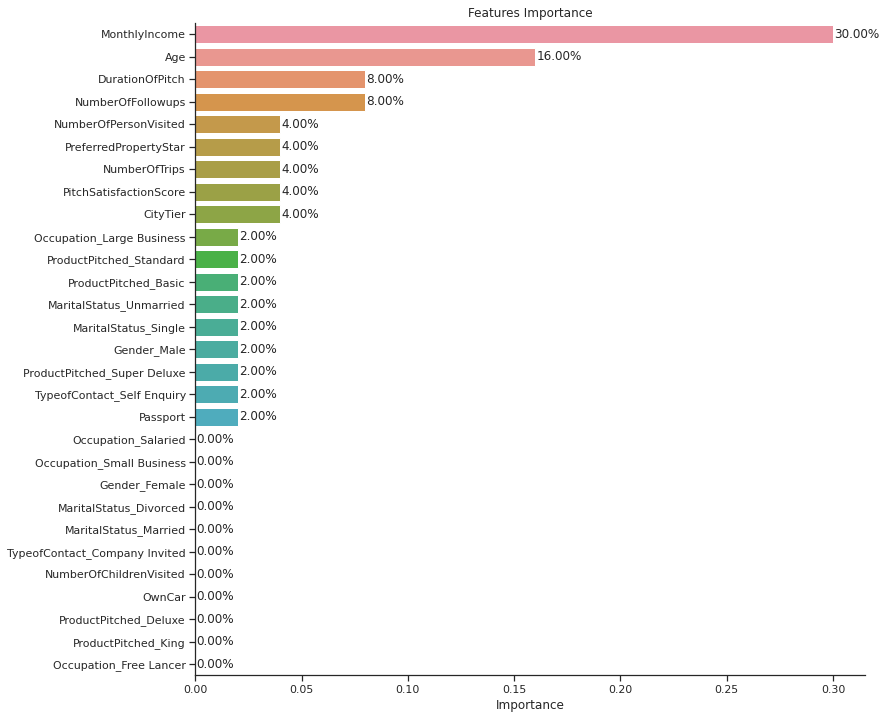

In [138]:
# Features Importance
features_importance(adaboost_original)

- Results for the AdaBoostClassifier with Default Parameters:
    
    Train Accuracy = 0.846, Test Accuracy = 0.845 | Train F1 Score: 0.433, Test F1 Score: 0.431
    
- Model might be slightly underfitting since the Train Set Accuracy got worse (0.846). 

- On the Test Set, the F1-Score (0.431) is not good enough.

- Most Important Features (top 04) are: 'MonthlyIncome', 'Age', 'DurationOfPitch' and 'NumerOfFollowups'.

### Gradient Boosting Classifier with Default Parameters

In [139]:
gradientboost_original = GradientBoostingClassifier(random_state = 1)
gradientboost_original.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

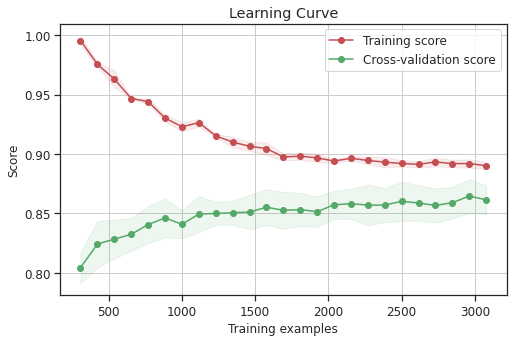

In [140]:
# A learning curve shows the validation and training score of an estimator for varying numbers of training samples.
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
skplt.estimators.plot_learning_curve(gradientboost_original, X_train, y_train, scoring = 'accuracy', cv = 10, train_sizes = np.linspace(.1, 1.0, 25), figsize = (8,5));

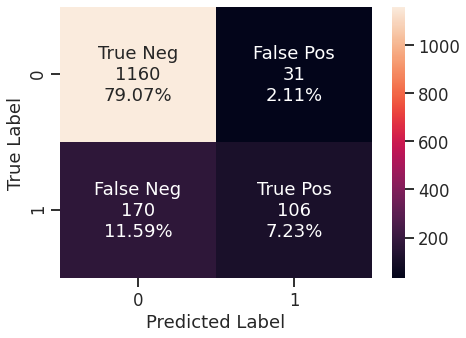

In [141]:
# Creating the Confusion Matrix for Gradient Boosting Classifier with Default Parameters
make_confusion_matrix(gradientboost_original, y_test)

In [142]:
# Recall on train and test
gradientboost_original_metrics = get_metrics_score(gradientboost_original)

Train Accuracy = 0.885
Test Accuracy = 0.863
Train Recall = 0.449
Test Recall = 0.384
Train Precision = 0.887
Test Precision = 0.774
Train F1 Score: 0.596
Test F1 Score: 0.513
ROC AUC Score: 0.881


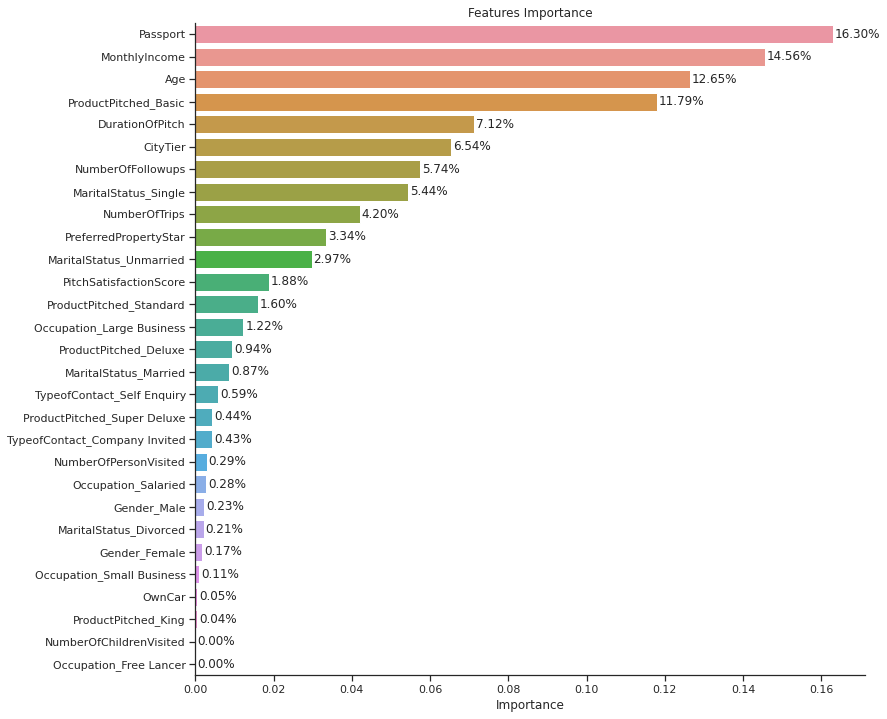

In [143]:
# Features Importance
features_importance(gradientboost_original)

- Results for the GradientBoostingClassifier with Default Parameters:
    
    Train Accuracy = 0.885, Test Accuracy = 0.863 | Train F1 Score: 0.596, Test F1 Score: 0.513
    
- Model might be slightly underfitting since the Train Set Accuracy got worse (0.885). 

- On the Test Set, the F1-Score (0.513) is not good enough.

- Most Important Features (top 05) are: 'Passport', 'MonthlyIncome', 'Age', 'ProductPitched_Basic' and 'DurationOfPitch'.

#### XGBoost Classifier with Default Parameters

In [144]:
xgboost_original = XGBClassifier(eval_metric = "logloss", random_state = 1)
xgboost_original.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

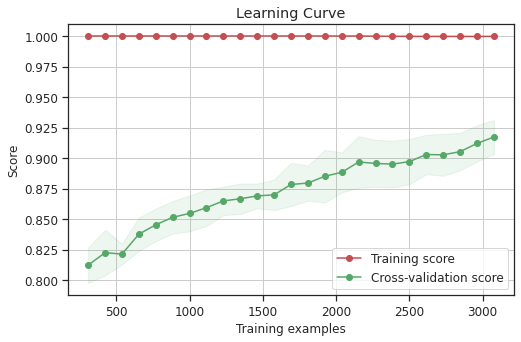

In [145]:
# A learning curve shows the validation and training score of an estimator for varying numbers of training samples.
# It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
skplt.estimators.plot_learning_curve(xgboost_original, X_train, y_train, scoring = 'accuracy', cv = 10, train_sizes = np.linspace(.1, 1.0, 25), figsize = (8,5));

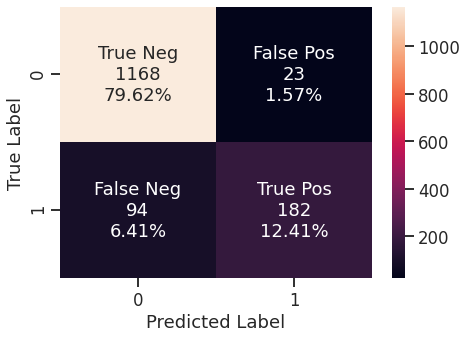

In [146]:
# Creating the Confusion Matrix for XGBoost Classifier with Default Parameters
make_confusion_matrix(xgboost_original, y_test)

In [147]:
# Metrics on Train and Test Sets
xgboost_original_metrics = get_metrics_score(xgboost_original)

Train Accuracy = 0.999
Test Accuracy = 0.92
Train Recall = 0.995
Test Recall = 0.659
Train Precision = 1.0
Test Precision = 0.888
Train F1 Score: 0.998
Test F1 Score: 0.757
ROC AUC Score: 0.953


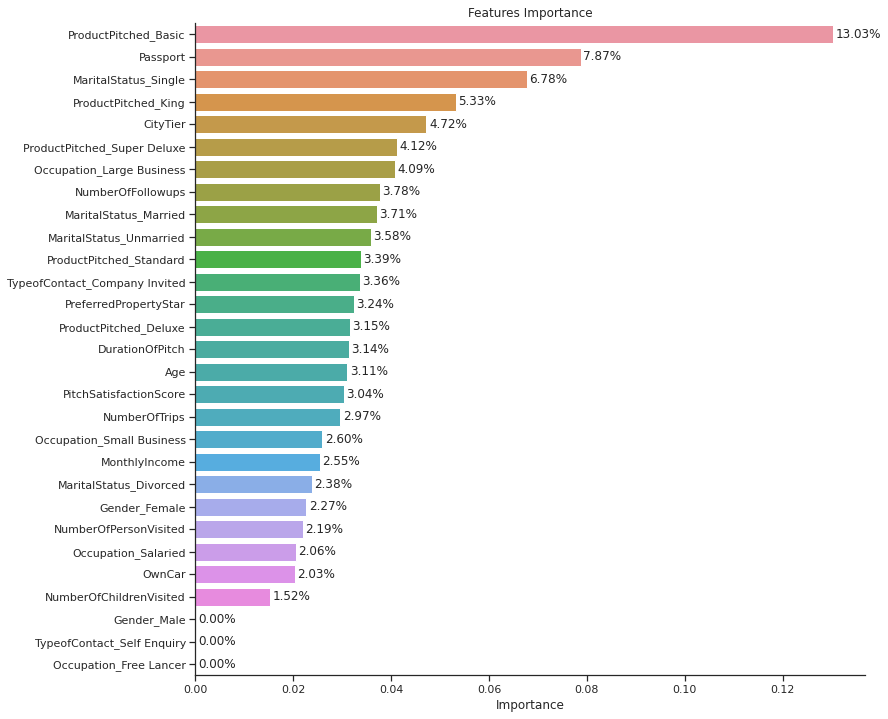

In [148]:
# Features Importance
features_importance(xgboost_original)

- Results for the XGBClassifier with Default Parameters:
    
    Train Accuracy = 0.999, Test Accuracy = 0.92 | Train F1 Score: 0.998, Test F1 Score: 0.757
    
- Both Train Set and Test Set Accuracies are close, not representing an overfitting problem.

- Test Set F1 Score of 0.757 is slightly better than the score from the previous models, being very close to RandomForestClassifier with Hyperparameters Tuning (0.741) and Bagging Classifier with Hyperparameters Tuning (0.752).

- Most Important Features (top 05) are: 'ProductPitched_Basic', 'Passport', 'MaritalStatus_Single', 'ProductPitchedKing' and 'CityTier'.

#### Stacking Model with Default Parameters

In [149]:
estimators_default = [('Decision Tree Original', decision_tree_original), ('Bagging Original', bagging_original), ('Random Forest Original', random_forest_original),\
                      ('AdaBoost Original', adaboost_original), ('Gradient Boost Original', gradientboost_original), ('XGBoost Original', xgboost_original)]
final_estimator_default = XGBClassifier(random_state = 1)

In [150]:
stacking_estimator_original = StackingClassifier(estimators = estimators_default, final_estimator = final_estimator_default, cv = 5)
stacking_estimator_original.fit(X_train, y_train)

[10:41:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(cv=5,
                   estimators=[('Decision Tree Original',
                                DecisionTreeClassifier(random_state=1)),
                               ('Bagging Original',
                                BaggingClassifier(random_state=1)),
                               ('Random Forest Original',
                                RandomForestClassifier(random_state=1)),
                               ('AdaBoost Original',
                                AdaBoostClassifier(random_state=1)),
                               ('Gradient Boost Original',
                                GradientBoostingClassifier(random_state=1)),
                               ('XGBoo...
                                                 importance_type='gain',
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_delta_step=None,
  

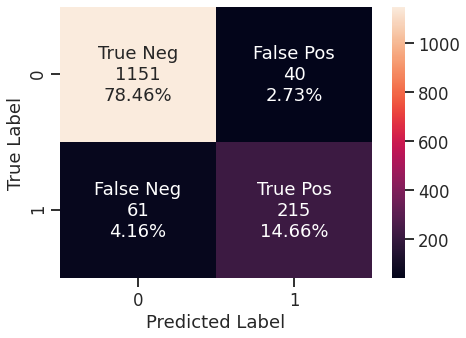

In [151]:
# Creating the Confusion Matrix for Stacking Model with Default Parameters
make_confusion_matrix(stacking_estimator_original, y_test)

In [152]:
# Metrics on Train and Test Sets
stacking_estimator_original_metrics = get_metrics_score(stacking_estimator_original)

Train Accuracy = 0.999
Test Accuracy = 0.931
Train Recall = 1.0
Test Recall = 0.779
Train Precision = 0.995
Test Precision = 0.843
Train F1 Score: 0.998
Test F1 Score: 0.81
ROC AUC Score: 0.958


- Results for the StackingClassifier with Default Parameters:
    
    Train Accuracy = 0.999, Test Accuracy = 0.931 | Train F1 Score: 0.998, Test F1 Score: 0.81
    
- Both Train Set and Test Set Accuracies are close, not representing an overfitting problem.

- Test Set F1 Score of 0.81 is the best gotten so far.

***
## Model Performance Evaluation and Improvement - Boosting <a class="anchor" id="7"></a>

- Comment on which metric is right for model performance evaluation and why? - Comment on model performance - Can model performance be improved? check and comment

#### AdaBoost Classifier with Tuned Hyperparameters

In [ ]:
adaboost_tuned = AdaBoostClassifier(random_state = 1)

# Grid of parameters to choose from
## add from article
parameters = {"base_estimator":[DecisionTreeClassifier(max_depth = 1), DecisionTreeClassifier(max_depth = 2), DecisionTreeClassifier(max_depth = 3)],
              "n_estimators": [50, 100, 150],
              "learning_rate":[0.1, 0.3, 0.5, 0.7, 0.9]}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(adaboost_tuned, parameters, scoring = acc_scorer, cv = 5, verbose = 20)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
adaboost_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
adaboost_tuned.fit(X_train, y_train)

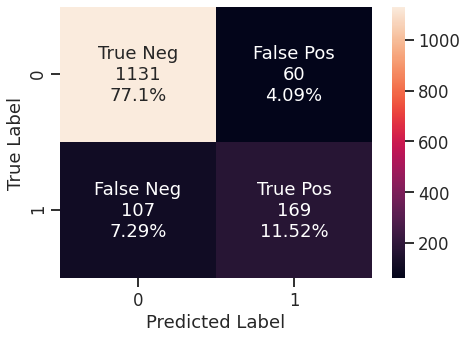

In [154]:
make_confusion_matrix(adaboost_tuned, y_test)

In [155]:
# Metrics on Train and Test Sets
adaboost_tuned_metrics = get_metrics_score(adaboost_tuned)

Train Accuracy = 0.998
Test Accuracy = 0.886
Train Recall = 0.992
Test Recall = 0.612
Train Precision = 0.998
Test Precision = 0.738
Train F1 Score: 0.995
Test F1 Score: 0.669
ROC AUC Score: 0.838


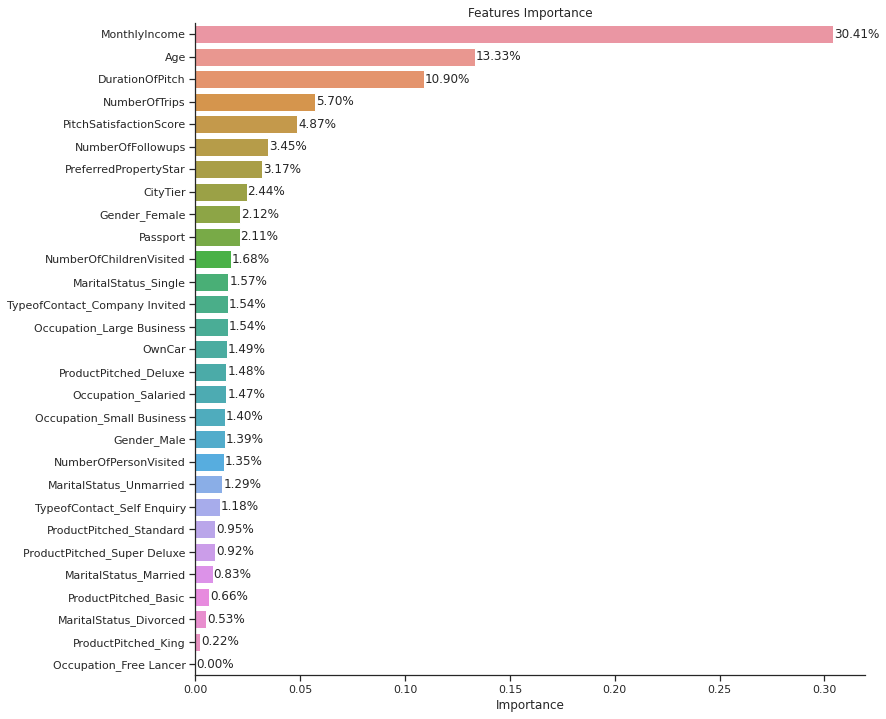

In [156]:
# Features Importance
features_importance(adaboost_tuned)

- A F1-Score metric was utilized as the objective for model tuning.

- Results for the AdaBoostClassifier with Hyperparameters Tunning:
    
    Train Accuracy = 0.998, Test Accuracy = 0.886 | Train F1 Score: 0.995, Test F1 Score: 0.669
    
- Both Train Set and Test Set Accuracies are relatively close, not necessarily representing an overfitting problem.

- Test Set F1 Score of 0.669 is comparable to RandomForestClassifier with default parameters (0.696), BaggingClassifier with default parameters (0.699) and DecisionTreeClassifier with default parameters (0.693) .

- Most Important Features (top 05) are: 'MonthlyIncome', 'Age', 'DurationOfPitch', 'NumberOfTrips' and 'PitchSatisfactionScore'.

### Gradient Boost Classifier with Tuned Hyperparameters

In [ ]:
gradientboost_tuned = GradientBoostingClassifier(random_state = 1)

# Grid of parameters to choose from
## add from article
parameters = {"init" : [None, AdaBoostClassifier(random_state = 1)],
              "n_estimators": [100, 150, 200, 250],
              "subsample":[0.8, 0.9, 1],
              "max_features":[0.7, 0.8, 0.9, 1]}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gradientboost_tuned, parameters, scoring = acc_scorer, cv = 5, verbose = 20)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gradientboost_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gradientboost_tuned.fit(X_train, y_train)

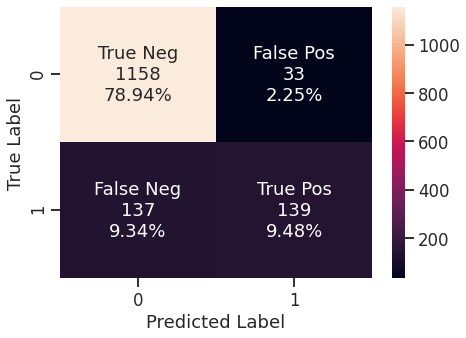

In [158]:
make_confusion_matrix(gradientboost_tuned, y_test)

In [159]:
# Recall on train and test
gradientboost_tuned_metrics = get_metrics_score(gradientboost_tuned)

Train Accuracy = 0.919
Test Accuracy = 0.884
Train Recall = 0.61
Test Recall = 0.504
Train Precision = 0.938
Test Precision = 0.808
Train F1 Score: 0.739
Test F1 Score: 0.621
ROC AUC Score: 0.902


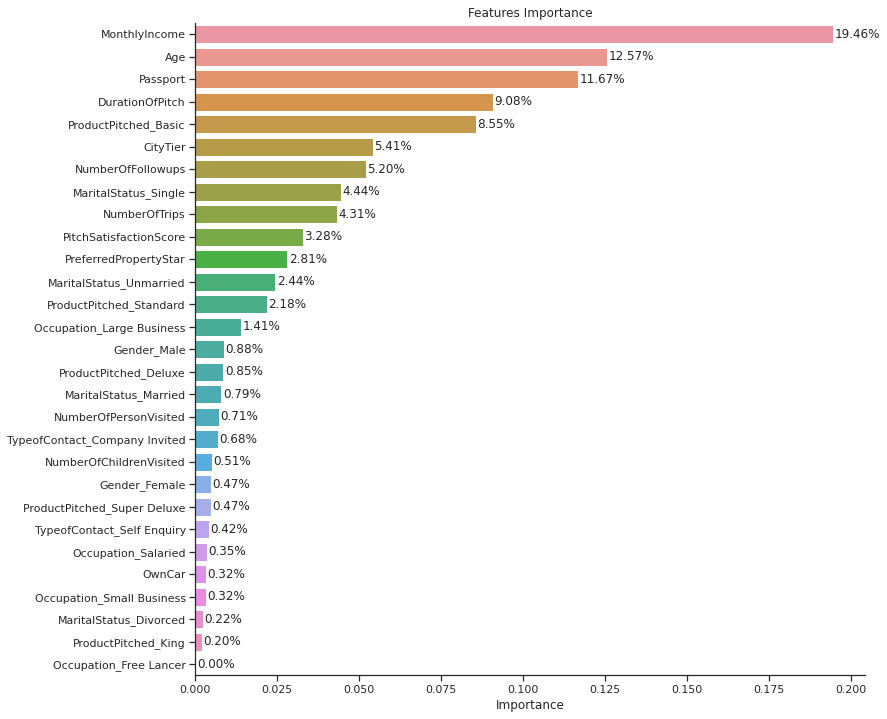

In [160]:
# Features Importance
features_importance(gradientboost_tuned)

- A F1-Score metric was utilized as the objective for model tuning.

- Results for the GradientBoostingClassifier with Hyperparameters Tunning:

    Train Accuracy = 0.919, Test Accuracy = 0.884 | Train F1 Score: 0.739, Test F1 Score: 0.621

- Both Train Set and Test Set Accuracies are very close, not representing an overfitting problem.

- Test Set F1 Score of 0.621 is comparable AdaBoostClassifier with Hyperparameters Tunning (0.669), RandomForestClassifier with default parameters (0.696), BaggingClassifier with default parameters (0.699) and DecisionTreeClassifier with default parameters (0.693) .

- Most Important Features (top 05) are: 'MonthlyIncome', 'Age', 'Passport', 'DurationOfPitch' and 'ProductPitched_Basic'.

#### XGBoost Classifier with Tuned Hyperparameters

In [ ]:
xgboost_tuned = XGBClassifier(eval_metric = "logloss", nthread = -1, random_state = 1)

# Grid of parameters to choose from
parameters = {"n_estimators" : np.arange(10, 100, 20),
              "scale_pos_weight" : [3, 5, 7],
              "subsample" : [0.70, 0.9, 1],
              "learning_rate" : [0.1, 0.2, 0.3],
              "gamma":[3, 5, 7],
              "colsample_bylevel":[0.3, 0.5, 0.7, 0.9]}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgboost_tuned, parameters, scoring = acc_scorer, cv = 5, verbose = 20)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgboost_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgboost_tuned.fit(X_train, y_train)

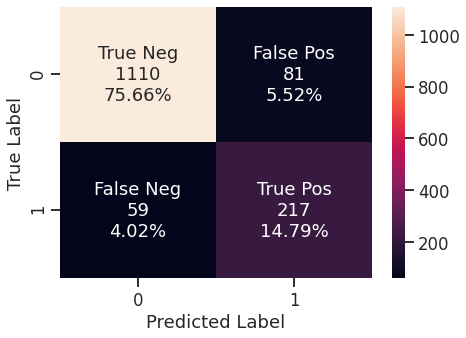

In [162]:
make_confusion_matrix(xgboost_tuned, y_test)

In [163]:
# Recall on train and test
xgboost_tuned_metrics = get_metrics_score(xgboost_tuned)

Train Accuracy = 0.985
Test Accuracy = 0.905
Train Recall = 0.998
Test Recall = 0.786
Train Precision = 0.928
Test Precision = 0.728
Train F1 Score: 0.962
Test F1 Score: 0.756
ROC AUC Score: 0.945


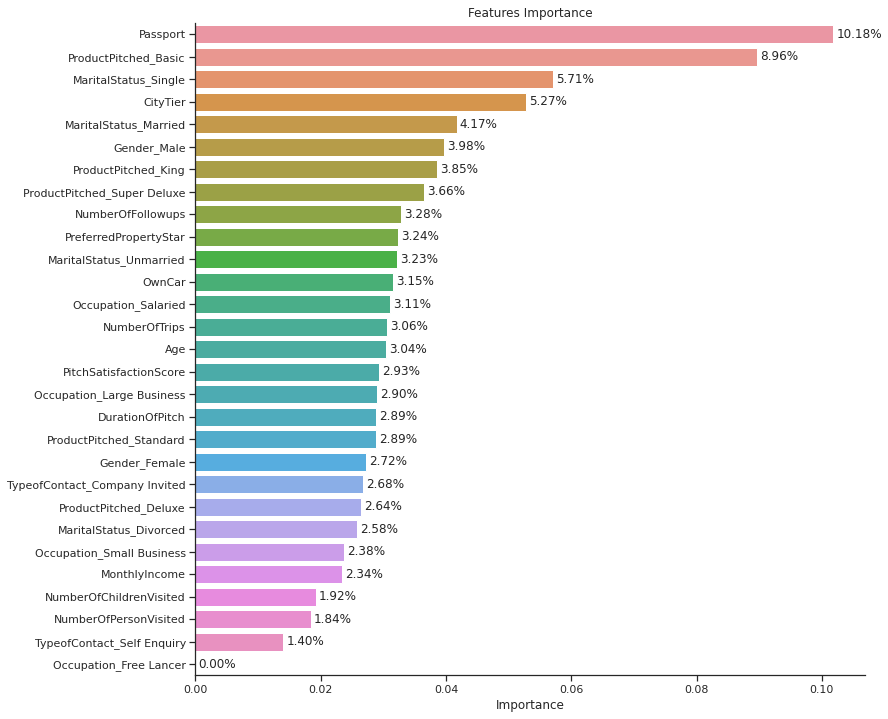

In [164]:
# Features Importance
features_importance(xgboost_tuned)

- A F1-Score metric was utilized as the objective for model tuning.

- Results for the GradientBoostingClassifier with Hyperparameters Tunning:

    Train Accuracy = 0.985, Test Accuracy = 0.905 | Train F1 Score: 0.962, Test F1 Score: 0.756

- Both Train Set and Test Set Accuracies are close, not representing an overfitting problem.

- Test Set F1 Score of 0.756 is comparable to BaggingClassifier with Hyperparameters Tuning (0.752), RandomForestClassifier with Hyperparameters Tuning (0.741) and XGBClassifier with Default Parameters (0.757) 

- Most Important Features (top 05) are: 'Passport', ProductPitched_Basic', 'MaritalStatus_Single', 'CityTier' and 'MaritalStatus_Married'.

#### Stacking Model with Tuned Hyperparameters

In [165]:
estimators_tuned = [('Decision Tree Tuned', decision_tree_tuned), ('Bagging Tuned', bagging_tuned), ('Random Forest Tuned', random_forest_tuned),\
                      ('AdaBoost Tuned', adaboost_tuned), ('Gradient Boost Tuned', gradientboost_tuned), ('XGBoost Tuned', xgboost_tuned)]
final_estimator_tuned = XGBClassifier(random_state = 1)

In [166]:
stacking_estimator_tuned = StackingClassifier(estimators = estimators_tuned, final_estimator = final_estimator_tuned, cv = 5)
stacking_estimator_tuned.fit(X_train, y_train)

[11:08:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


StackingClassifier(cv=5,
                   estimators=[('Decision Tree Tuned',
                                DecisionTreeClassifier(class_weight={0: 0.2,
                                                                     1: 0.8},
                                                       max_depth=4,
                                                       max_leaf_nodes=10,
                                                       min_impurity_decrease=0.0001,
                                                       random_state=1,
                                                       splitter='random')),
                               ('Bagging Tuned',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                                                  max_features=0.9,
                                                  max_samples=0.9,
                                                  n_estimators=35,
                                   

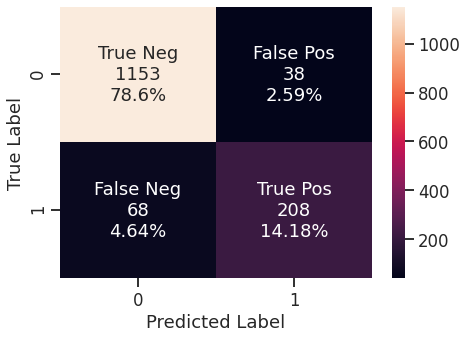

In [167]:
# Creating the Confusion Matrix for Stacking Model with Default Parameters
make_confusion_matrix(stacking_estimator_tuned, y_test)

In [168]:
# Metrics on Train and Test Sets
stacking_estimator_tuned_metrics = get_metrics_score(stacking_estimator_tuned)

Train Accuracy = 0.997
Test Accuracy = 0.928
Train Recall = 0.997
Test Recall = 0.754
Train Precision = 0.989
Test Precision = 0.846
Train F1 Score: 0.993
Test F1 Score: 0.797
ROC AUC Score: 0.949


- Results for the StackingClassifier with Hyperparameters Tunning:

    Train Accuracy = 0.997, Test Accuracy = 0.928 | Train F1 Score: 0.993, Test F1 Score: 0.797

- Both Train Set and Test Set Accuracies are close, not representing an overfitting problem.

- Test Set F1 Score of 0.797 is comparable to StackingClassifier with Default Parameters(0.81).

***
## Actionable Insights & Recommendations <a class="anchor" id="8"></a>

- Compare models - Business recommendations and insights

#### Comparing all models

In [169]:
# Defining list of models
models = [decision_tree_original, bagging_original, random_forest_original, decision_tree_tuned, bagging_tuned, random_forest_tuned,\
          adaboost_original, gradientboost_original, xgboost_original, adaboost_tuned, gradientboost_tuned, xgboost_tuned,\
          stacking_estimator_original, stacking_estimator_tuned]

# Defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
F1_train = []
F1_test = []
ROC_AUC_score = []

# Looping through all the models to get the metrics
for model in models:
    j = get_metrics_score(model, False)
    acc_train.append(np.round(j[0],3))
    acc_test.append(np.round(j[1],3))
    recall_train.append(np.round(j[2],3))
    recall_test.append(np.round(j[3],3))
    precision_train.append(np.round(j[4],3))
    precision_test.append(np.round(j[5],3))
    F1_train.append(np.round(j[6],3))
    F1_test.append(np.round(j[7],3))
    ROC_AUC_score.append(np.round(j[8],3))

In [170]:
# Creating a comparison dataframe with the metrics for all the models 
comparison_frame = pd.DataFrame({'Model':['Decision Tree','Bagging','Random Forest',
                                          'Tuned Decision Tree','Tuned Bagging','Tuned Random Forest',
                                          'AdaBoost', 'Gradient Boosting', 'XGBoost',
                                          'Tuned AdaBoost', 'Tuned Gradient Boosting', 'Tuned XGBoost',
                                          'Stacking', 'Tuned Stacking'],
                                 'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                 'Train_Recall':recall_train,'Test_Recall':recall_test,
                                 'Train_Precision':precision_train,'Test_Precision':precision_test,
                                 'Train_F1_Score':F1_train,'Test_F1_Score':F1_test,
                                 'ROC_AUC_Score':ROC_AUC_score}) 
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0             Decision Tree           1.000          0.885         1.000   
1                   Bagging           0.994          0.906         0.970   
2             Random Forest           1.000          0.909         1.000   
3       Tuned Decision Tree           0.792          0.795         0.579   
4             Tuned Bagging           1.000          0.921         1.000   
5       Tuned Random Forest           0.999          0.915         0.998   
6                  AdaBoost           0.846          0.845         0.312   
7         Gradient Boosting           0.885          0.863         0.449   
8                   XGBoost           0.999          0.920         0.995   
9            Tuned AdaBoost           0.998          0.886         0.992   
10  Tuned Gradient Boosting           0.919          0.884         0.610   
11            Tuned XGBoost           0.985          0.905         0.998   
12                 Stacking           0.999          0.931         1.000   
13           Tuned Stacking           0.997          0.928         0.997   

    Test_Recall  Train_Precision  Test_Precision  Train_F1_Score  \
0         0.692            1.000           0.695           1.000   
1         0.580            0.995           0.879           0.983   
2         0.551            1.000           0.944           1.000   
3         0.612            0.458           0.466           0.512   
4         0.638            1.000           0.917           1.000   
5         0.641            0.994           0.876           0.996   
6         0.312            0.705           0.699           0.433   
7         0.384            0.887           0.774           0.596   
8         0.659            1.000           0.888           0.998   
9         0.612            0.998           0.738           0.995   
10        0.504            0.938           0.808           0.739   
11        0.786            0.928           0.728           0.962   
12        0.779            0.995           0.843           0.998   
13        0.754            0.989           0.846           0.993   

    Test_F1_Score  ROC_AUC_Score  
0           0.693          0.811  
1           0.699          0.930  
2           0.696          0.968  
3           0.529          0.766  
4           0.752          0.954  
5           0.741          0.964  
6           0.431          0.835  
7           0.513          0.881  
8           0.757          0.953  
9           0.669          0.838  
10          0.621          0.902  
11          0.756          0.945  
12          0.810          0.958  
13          0.797          0.949

In [171]:
# Sorting the models by F1-Score metric (ascending order)
comparison_frame.sort_values(["Test_F1_Score"], ascending = True, inplace = True)

In [172]:
# Data preparation to create a lineplot with a hue per metric
comparison_frame_melted = pd.melt(frame = comparison_frame, id_vars=['Model'], value_name = 'Metric Value')

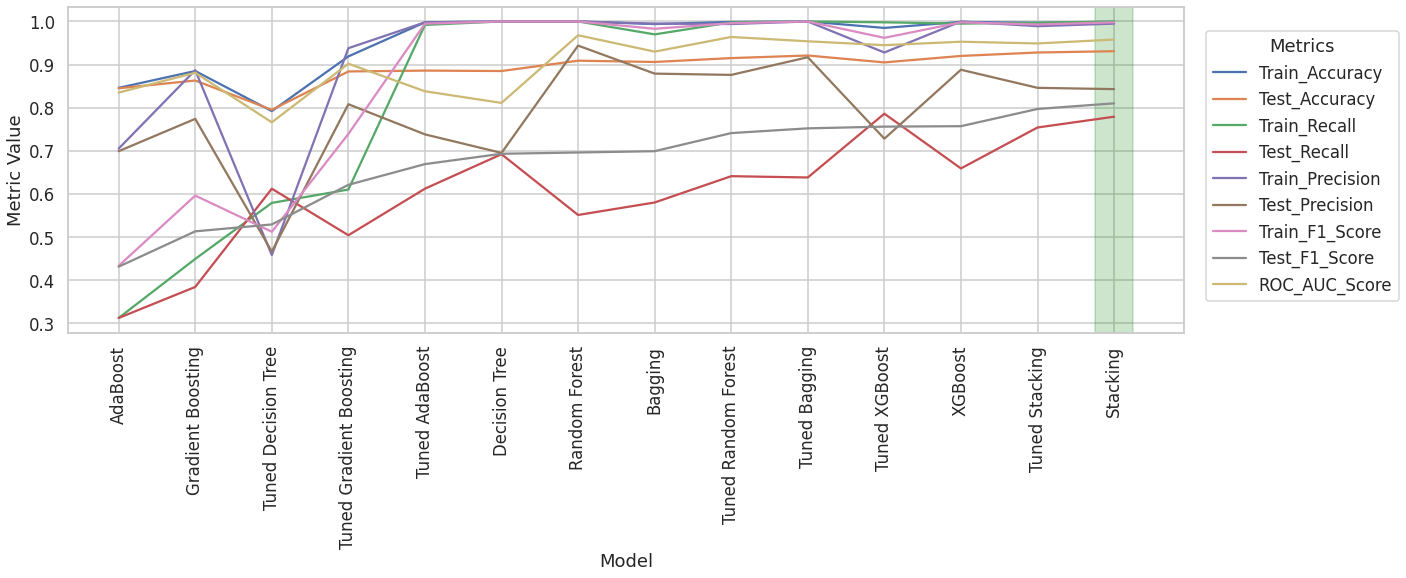

In [173]:
# Lineplot with a hue per metric for all the models, sorted by F1 Score on the Test Set
sns.set({'figure.figsize': (20,6)})
sns.set_style("whitegrid")
sns.set_context("talk")
chart = sns.lineplot(x = "Model", y = "Metric Value", hue = "variable", data = comparison_frame_melted)
chart.figure.canvas.draw()
x = chart.get_xticklabels()
chart.set_xticklabels(x, rotation = 90)
chart.legend(loc = 'upper right', title = 'Metrics', bbox_to_anchor=(1.2, 0.95))
chart.axvspan(12.75, 13.25, color = 'green', alpha = 0.2);

- Based on the model comparison summary given by the plot above, the Stacking Classifier (with Default Parameters) was selected as the best option since it combined all metrics in a more balanced manner (highlighted in "green" on the plot above)

- Other classfiers like Tunned Stacking, XGBoost and Tuned XGBoost also performed very well.

done in 31.622s


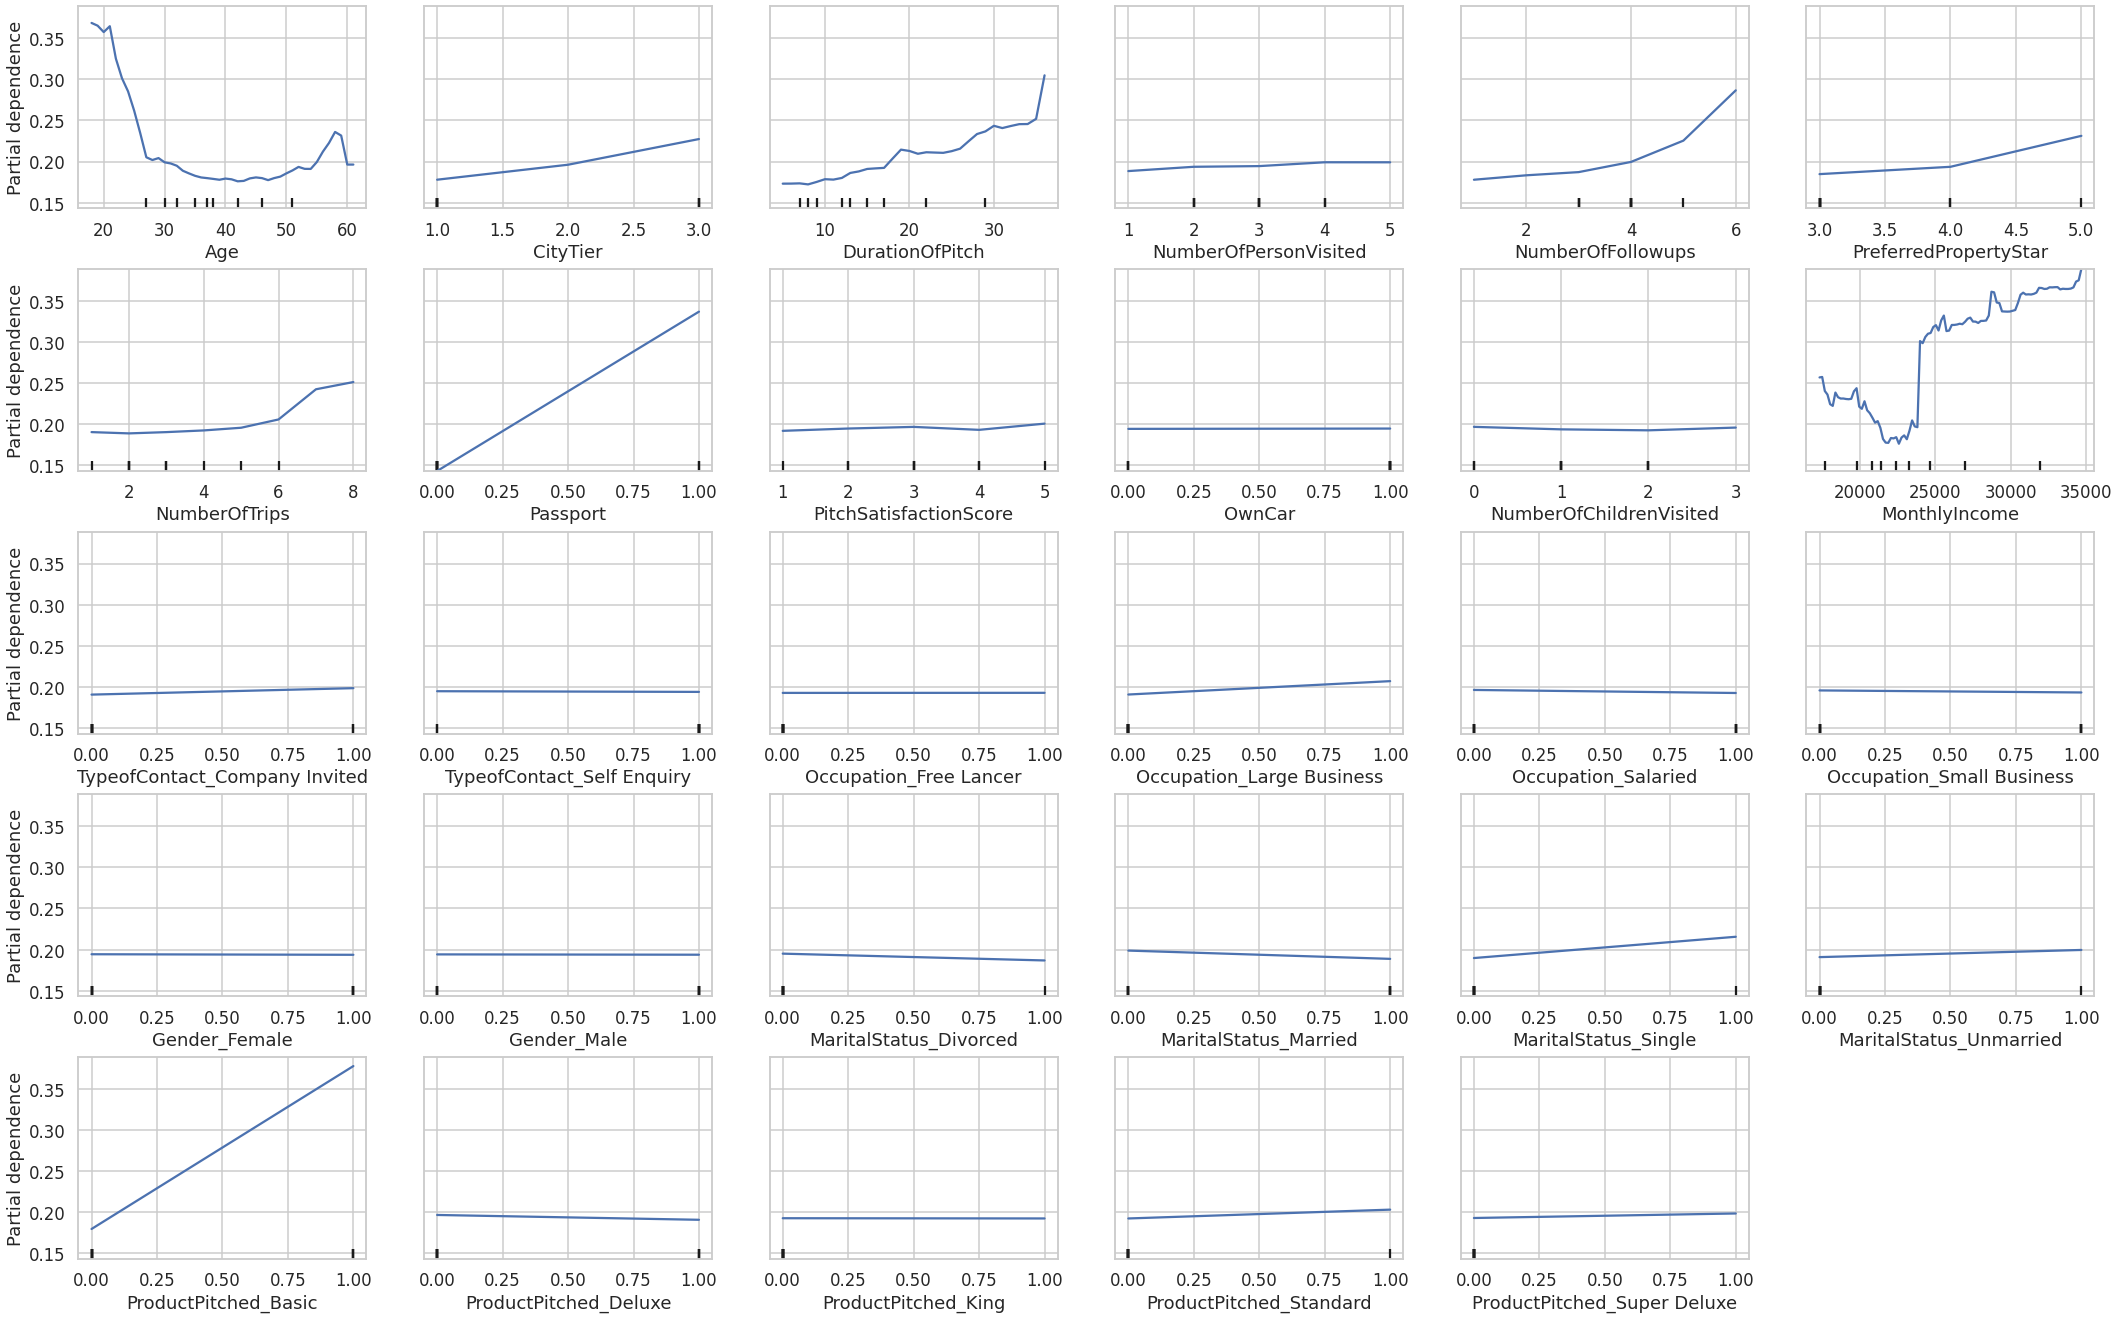

In [174]:
# Creation of Partial Dependence Plot for all Variables
# Partial Dependence Plots (PDP) show the dependence between the target response and a set of input features of interest.
# Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.
tic = time()
plot_partial_dependence(estimator = stacking_estimator_original, X = X_train, features = feature_names, n_cols = 6)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.subplots_adjust(left = 0, right = 1.4, bottom = 0.01, hspace = 0.3)
fig.set_figheight(20)

done in 26.596s


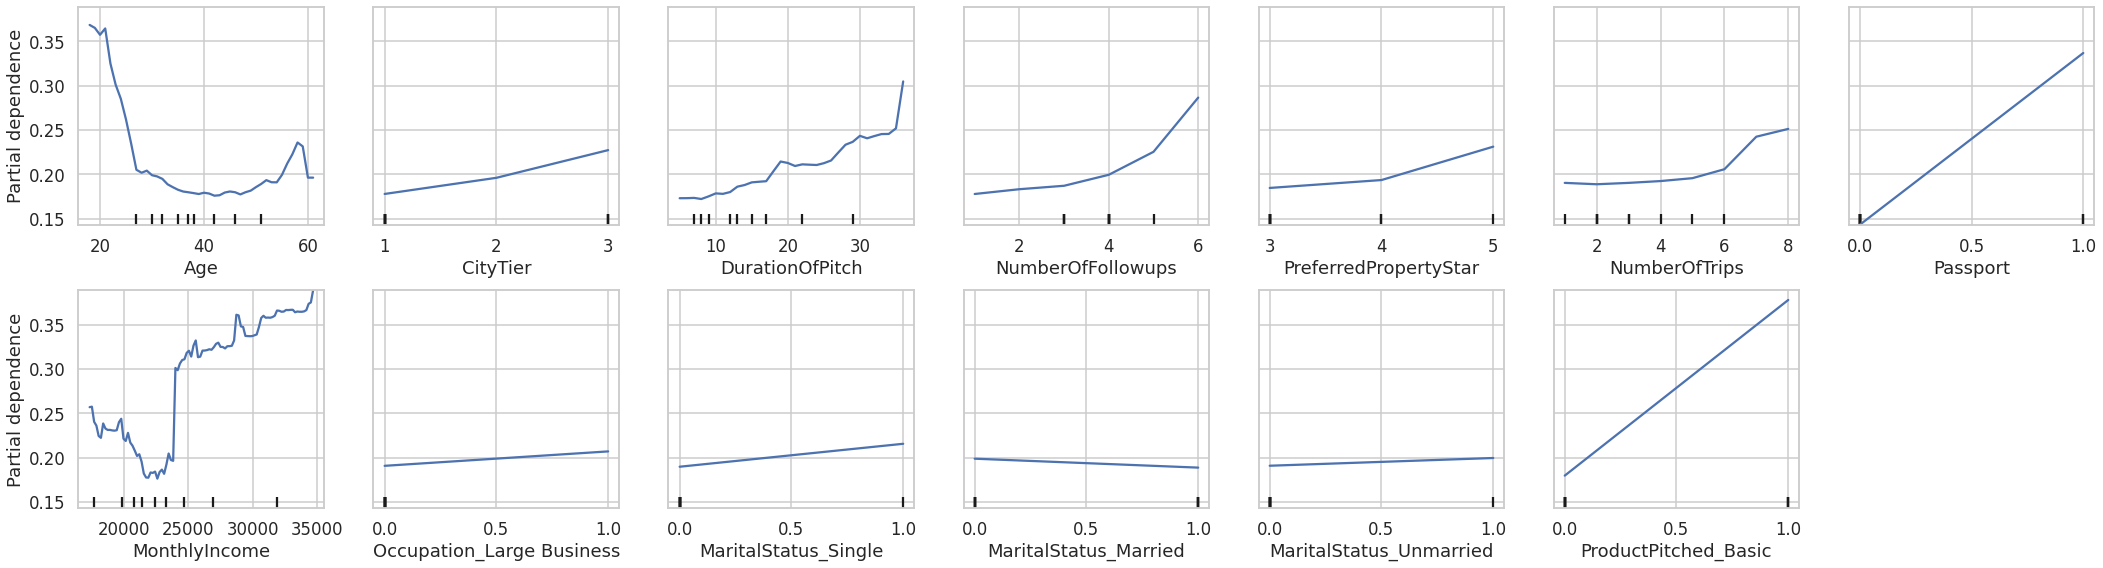

In [175]:
# Partial Dependence Plots (PDP) only for the most important features (larger effects)
tic = time()
plot_partial_dependence(estimator = stacking_estimator_original, X = X_train, features = ['Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups',\
                                                                                          'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'MonthlyIncome',\
                                                                                          'Occupation_Large Business', 'MaritalStatus_Single', 'MaritalStatus_Married',\
                                                                                          'MaritalStatus_Unmarried', 'ProductPitched_Basic'], n_cols = 7)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.subplots_adjust(left = 0, right = 1.4, bottom = 0.01, hspace = 0.3)
fig.set_figheight(8)

Important Insights (as per the EDA and PDP from the selected classifier):

- Younger Customers (approximately less than 30 years old) are more likely to buy a travel package.
    
- Customers from 'CityTier' 2 and 3 are more likely to buy a travel package. This is matching to what was seen at the EDA session since categories 2 and 3 represented a higher percentage of packages taken when compared to 'CityTier1' category 1.

- A 'DurationOfPitch' above 20 is likely to increase the travel package sales. 

- Regarding the 'NumberOfFollowups' variable, an increased number of follow up with the Customers would increase the chances of closing a deal. This is matching to what was seen at the EDA session since the categories 5 and 6 presented a higher percentage of products taken when compared to the other categories.

- On 'PreferredPropertyStar', the Customers are more likely to choose the packages related to properties with higher star rating. This is matching to what was seen at the EDA session since 'PreferredPropertyStar' category 5 had a higher percentage of products taken when compared with the other categories.

- For 'NumberOfTrips', the Customers who intended to take more trips in a year are more likely to buy the travel package. This is also matching on what was seem at the EDA session since a higher percentage of products taken was associated with 'NumberOfTrips' categories 7 and 8, when compared with the other categories.

- Customer who have passports are more likely to buy a travel package. This variable also stood out at the EDA session and has one of the largest slopes (significance) on the PDP above.

- Customers with monthly incomes higher than approximate 25000 are more likely to buy a travel package.

- Customer from 'Occupation' category 'Large Business' are more likely to buy a travel package. This is also matching on what was seen at the EDA session.

- 'Single' and 'Unmarried' Customers are more likely to buy a travel package. In the other hand, 'Married' Customers are lees likely to buy a travel package.

- A 'Basic' type of package is also more attractive and increases the likelihood for Customers to buy the travel package. This variable also stood out at the EDA session and has one of the largest slopes (significance) on the PDP above.

- We can use this predictive model to enable the Tourism Company to establish a viable business model and to expand the Customer base.
- By introducing a new offering of packages, those are the key points the Company could explore to potentially increase the number of Customers and to turn the Marketing campaigns more efficient:

    - Focus on single or unmarried younger Costumers (approximately less than 30 years) who work on large business and have higher monthly income (approximately more than 25000).
    - Focus on Customers from city tiers 2 and 3, who are willing to travel at least 6 times per year.
    - Focus on Customer who own or are intending to get a passport to travel. This is such an important variable and the Tourism Company could offer to support the Customers to get their passports in a convenient manner, or even paying for their passport expenses if they close a deal.
    - An effective and satisfactory pitch, with duration of at least 20 (here I guess the unit is in 'minutes') and more than 4 follow-up sessions.
    - Ensure that higher star rating properties (4-5) are included in the travel packages.
    - Offer more options for Basic package types. This is also a very important variable which can make a relevant difference and convince the Customers to adhere to a long term travel package.